In [ ]:
import json
import os
from os.path import join

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from _drugex_environment import get_environ_dict
from cycler import cycler
from IPython.display import display
from PIL import Image, ImageColor, ImageDraw, ImageFont
from qsprpred.data import QSPRDataset
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import MolsToGridImage, SetACS1996Mode, rdMolDraw2D
from PIL import Image, ImageDraw, ImageFont, ImageColor

a2arcolors = ["#FFCEAD", "#AAC5AC", "#447464", "#575463", "#9E949D", "#C46D5E", "#F4AC32"]
a2arcolors_rgba = [ImageColor.getcolor(c, "RGBA") for c in a2arcolors]
COLOR = '#5A5766'
def set_theme():
    # set color palette
    sns.reset_defaults()

    mpl.rcParams['axes.prop_cycle'] = cycler(color=a2arcolors)
    sns.set_palette(a2arcolors)
    
    mpl.rcParams.update({'font.size': 15})
    mpl.rcParams['text.color'] = COLOR
    mpl.rcParams['axes.labelcolor'] = COLOR
    mpl.rcParams['xtick.color'] = COLOR
    mpl.rcParams['ytick.color'] = COLOR
    mpl.rcParams['axes.edgecolor'] = COLOR
set_theme()

display(sns.color_palette(a2arcolors))

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


[(1.0, 0.807843137254902, 0.6784313725490196),
 (0.6666666666666666, 0.7725490196078432, 0.6745098039215687),
 (0.26666666666666666, 0.4549019607843137, 0.39215686274509803),
 (0.3411764705882353, 0.32941176470588235, 0.38823529411764707),
 (0.6196078431372549, 0.5803921568627451, 0.615686274509804),
 (0.7686274509803922, 0.42745098039215684, 0.3686274509803922),
 (0.9568627450980393, 0.6745098039215687, 0.19607843137254902)]

In [2]:
config_file = "../config.json"
with open(config_file, "r") as f:
    config = json.load(f)

QSPR_DIR = join(config["BASE_DIR"], config["PROCESSED_DATA_DIR"], "QSPR/")
DNDD_DIR = join(config["BASE_DIR"], config["PROCESSED_DATA_DIR"], "DNDD/")
FINETUNE_DIR = join(DNDD_DIR, "finetuned")
REINFORCE_DIR = join(DNDD_DIR, "reinforced")
GENERATED_DIR = join(DNDD_DIR, "generated")
FIGURES_DIR = join(config["BASE_DIR"], config["FIGURES_DIR"], "DNDD/")
os.makedirs(FIGURES_DIR, exist_ok=True)

# import scoring functions used in the DNDD pipeline
(
    A2AR_scorer, 
    FUmax_scorer, FUmin_scorer, 
    VDSSmax_scorer, VDSSmin_scorer,
    CLmax_scorer, CLmin_scorer
) = get_environ_dict(
    QSPR_PATH=join(QSPR_DIR, "models"),
    A2AR_model=config["A2AR_MODEL"],
    FU_model=config["FU_MODEL"],
    VDSS_model=config["VDSS_MODEL"],
    CL_model=config["CL_MODEL"],
    return_scorers=True
)

# list all result folders
finetuning_folders = os.listdir(FINETUNE_DIR)
finetuning_folders = [f for f in finetuning_folders if not f.startswith("conda_env") and not f.startswith("Finetuning")]
finetuning_folders

reinforce_folders = os.listdir(REINFORCE_DIR)
reinforce_folders = [f for f in reinforce_folders if not f.startswith("conda_env") and not f.startswith("ReinforcementLearning")]
reinforce_folders

generated_folders = os.listdir(GENERATED_DIR)
generated_folders = [f for f in generated_folders if not f.startswith("conda_env") and not f.startswith("Generated") and not f.startswith("umap") and not f.startswith("Umap")]
generated_folders_rep_0 = [f for f in generated_folders if f.endswith("_0") or f.endswith("_finetuned") or f.endswith("pretrained")]
generated_folders_rep_1 = [f for f in generated_folders if f.endswith("_1") or f.endswith("_finetuned") or f.endswith("pretrained")]
generated_folders_rep_2 = [f for f in generated_folders if f.endswith("_2") or f.endswith("_finetuned") or f.endswith("pretrained")]

# make a list of generated folders for finetuned and reinforced models separately
generated_folders_reinforced = [f for f in generated_folders if not "finetuned" in f and not f == "pretrained"]

# dictionary of scenario names
scenario_dict = {
    "pretrained": "pretrained",
    "A2AR_finetuned": "finetuned on A2AR dataset",
    "A2AR": "maximize A2AR",
    "FU_finetuned": "finetuned on FU dataset",
    "FUmin": "minimize FU",
    "FUmax": "maximize FU",
    "VDSS_finetuned": "finetuned on VDSS dataset",
    "VDSSmin": "minimize VDSS",
    "VDSSmax": "maximize VDSS",
    "CL_finetuned": "finetuned on CL dataset",
    "CLmin": "minimize CL",
    "CLmax": "maximize CL",
    "A2AR_FU_finetuned": "finetuned on A2AR + FU dataset",
    "A2AR_FUmin": "maximize A2AR + minimize FU",
    "A2AR_FUmax": "maximize A2AR + maximize FU",
    "A2AR_VDSS_finetuned": "finetuned on A2AR + VDSS dataset",
    "A2AR_VDSSmin": "maximize A2AR + minimize VDSS",
    "A2AR_VDSSmax": "maximize A2AR + maximize VDSS",
    "A2AR_CL_finetuned": "finetuned on A2AR + CL dataset",
    "A2AR_CLmin": "maximize A2AR + minimize CL",
    "A2AR_CLmax": "maximize A2AR + maximize CL",
}

# create dictionary mapping scenario to list of objectives
scenario_property_dict = {}
for scenario in scenario_dict.keys():
    # remove _finetuned, min, max from scenario name
    properties = scenario.replace("_finetuned", "").replace("min", "").replace("max", "")
    # split scenario name into list of objectives
    scenario_property_dict[scenario] = properties.split("_")
print(f"Scenario property dict: {scenario_property_dict}")

# Dictionary of scenario combinations (finetuned and reinforced)
combinations_dict = {
    "A2AR": ('A2AR', 'A2AR_finetuned'),
    "FU": ('FUmin', 'FU_finetuned', 'FUmax'),
    "VDSS": ('VDSSmin', 'VDSS_finetuned', 'VDSSmax'),
    "CL":   ('CLmin', 'CL_finetuned', 'CLmax'),
    "A2AR_FU": ('A2AR_FUmin', 'A2AR_FU_finetuned', 'A2AR_FUmax'),
    "A2AR_VDSS": ('A2AR_VDSSmin', 'A2AR_VDSS_finetuned', 'A2AR_VDSSmax'),
    "A2AR_CL": ('A2AR_CLmin', 'A2AR_CL_finetuned', 'A2AR_CLmax'),
}

# dictionary mapping objective to scorer column names
objective_scorer_dict = {
    'pretrained': 'A2AR_scorer',
    'A2AR': 'A2AR_scorer',
    'FU': 'FUmax_scorer',
    'CL': 'CLmax_scorer',
    'VDSS': 'VDSSmax_scorer'
}
# dictionary mapping scenario to list of scorer column names
scenario_scorer_dict = {}
for scenario in scenario_dict.keys():
    scenario_scorer_dict[scenario] = [
        objective_scorer_dict[objective]
        for objective in objective_scorer_dict.keys()
        if objective in scenario
    ]
print(f"Scenario scorer dict: {scenario_scorer_dict}")

# dictionary mapping objective to applicability scorer column names
scorer_applicability_dict = {
    'A2AR_scorer': 'A2AR_applicability_scorer',
    'FUmax_scorer': 'FU_applicability_scorer',
    'VDSSmax_scorer': 'VDSS_applicability_scorer',
    'CLmax_scorer': 'CL_applicability_scorer'
}

# dictionary mapping scorer column names to objectives
scorer_property_dict = {
    "A2AR_scorer": "A2AR",
    "FUmax_scorer": "FU",
    "FUmin_scorer": "FU",
    "VDSSmax_scorer": "VDSS",
    "VDSSmin_scorer": "VDSS",
    "CLmax_scorer": "CL",
    "CLmin_scorer": "CL"
}

# dictionary mapping objective to property name for plotting
property_name_dict = {
    'A2AR': 'A2AR pKi (M)',
    'FU': 'Sqrt(Fraction unbound)',
    'VDSS': 'Log(Volume of distribution) (L/kg)',
    'CL': 'Log(Clearance) (mL/min/kg)'
}

Scenario property dict: {'pretrained': ['pretrained'], 'A2AR_finetuned': ['A2AR'], 'A2AR': ['A2AR'], 'FU_finetuned': ['FU'], 'FUmin': ['FU'], 'FUmax': ['FU'], 'VDSS_finetuned': ['VDSS'], 'VDSSmin': ['VDSS'], 'VDSSmax': ['VDSS'], 'CL_finetuned': ['CL'], 'CLmin': ['CL'], 'CLmax': ['CL'], 'A2AR_FU_finetuned': ['A2AR', 'FU'], 'A2AR_FUmin': ['A2AR', 'FU'], 'A2AR_FUmax': ['A2AR', 'FU'], 'A2AR_VDSS_finetuned': ['A2AR', 'VDSS'], 'A2AR_VDSSmin': ['A2AR', 'VDSS'], 'A2AR_VDSSmax': ['A2AR', 'VDSS'], 'A2AR_CL_finetuned': ['A2AR', 'CL'], 'A2AR_CLmin': ['A2AR', 'CL'], 'A2AR_CLmax': ['A2AR', 'CL']}
Scenario scorer dict: {'pretrained': ['A2AR_scorer'], 'A2AR_finetuned': ['A2AR_scorer'], 'A2AR': ['A2AR_scorer'], 'FU_finetuned': ['FUmax_scorer'], 'FUmin': ['FUmax_scorer'], 'FUmax': ['FUmax_scorer'], 'VDSS_finetuned': ['VDSSmax_scorer'], 'VDSSmin': ['VDSSmax_scorer'], 'VDSSmax': ['VDSSmax_scorer'], 'CL_finetuned': ['CLmax_scorer'], 'CLmin': ['CLmax_scorer'], 'CLmax': ['CLmax_scorer'], 'A2AR_FU_finetuned':

### Finetuning
Plots and information about the finetuning process.
1. Printed percentiles of the property values in the finetuning dataset. (Supplementary Table S1)
2. Plot of the training and validation loss during finetuning. (Supplementary Figure S4)

The percentiles displayed below were calculated from the experimental property values in the finetuning datasets. 
These percentiles were then used to determine the min and max values for clipped scaling of the property values in the reinforcement learning scenarios.
(see `_drugex_environment.py`)

In [ ]:
#####------------------------PERCENTILES FOR REINFORCEMENT LEARNING OBJECTIVES (Supplmentary Table S1)------------------------#####
property_percentiles = {}

for property in ["A2AR", "FU", "VDSS", "CL"]:
    df_train = pd.read_csv(f"{DNDD_DIR}/finetuned/{property}/train_df.tsv", sep="\t")
    perc10 = df_train[property].quantile(0.1).round(2)
    perc50 = df_train[property].quantile(0.5).round(2)
    perc90 = df_train[property].quantile(0.9).round(2)
    print(f"10th percentile of {property}: {perc10}")
    print(f"50th percentile of {property}: {perc50}")
    print(f"90th percentile of {property}: {perc90}")
    property_percentiles[property] = (perc10, perc50, perc90)
    

10th percentile of A2AR: 5.5
50th percentile of A2AR: 6.9
90th percentile of A2AR: 8.6
10th percentile of FU: 0.1
50th percentile of FU: 0.45
90th percentile of FU: 0.95
10th percentile of VDSS: -0.74
50th percentile of VDSS: 0.0
90th percentile of VDSS: 0.95
10th percentile of CL: -0.13
50th percentile of CL: 0.69
90th percentile of CL: 1.34


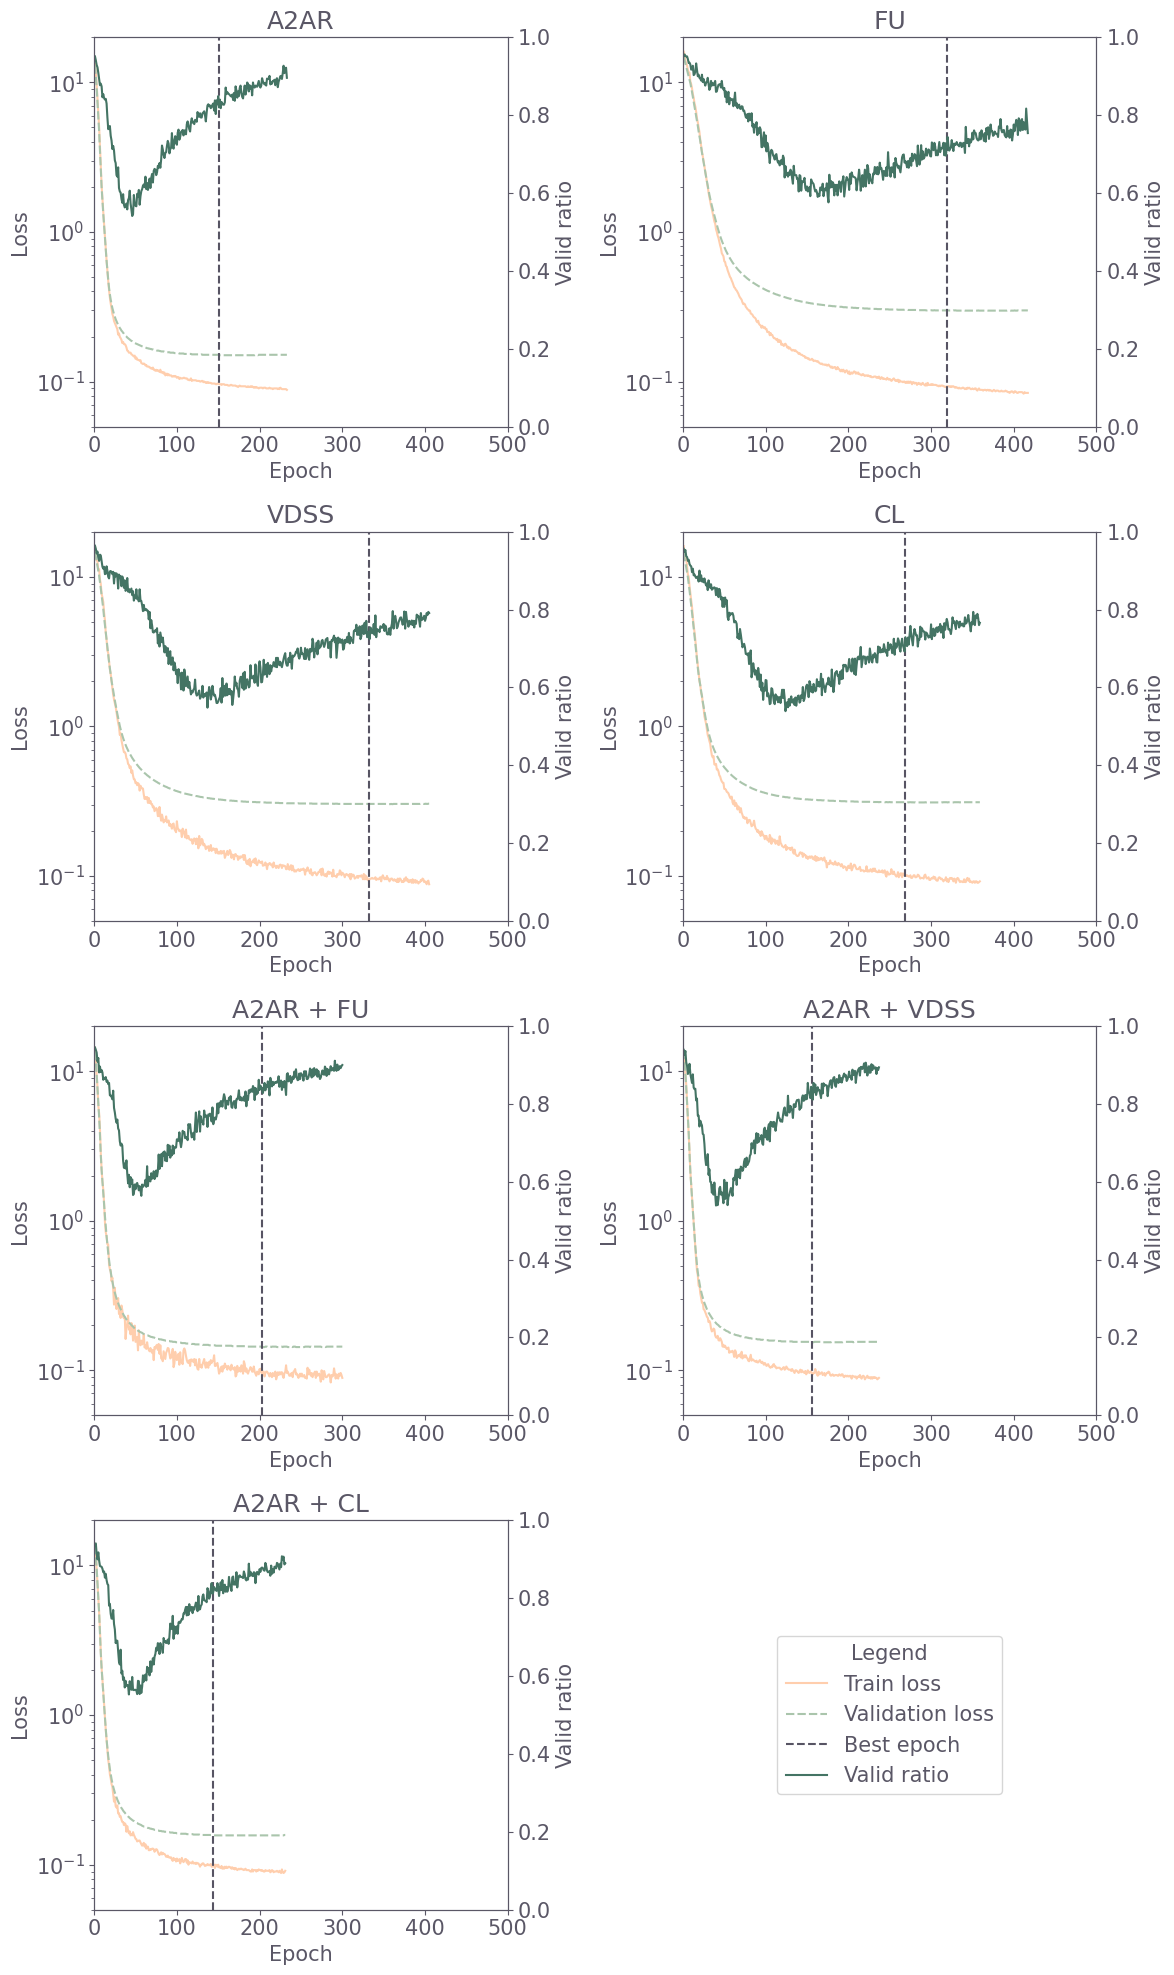

In [ ]:
#####--------------FINETUNING FIT PLOT (Supplementary Figure S4)---------------#####

fig, axes = plt.subplots(4, 2, figsize=(12, 20))
for i, folder in enumerate(combinations_dict.keys()):
    # Create a lineplot for each scenario
    ax = axes.flatten()[i]
    finetuning_fit = pd.read_csv(
        f"{FINETUNE_DIR}/{folder}/finetuned_fit.tsv", sep="\t"
    ).set_index("Epoch")
    sns.lineplot(data=finetuning_fit[['loss_train', 'loss_valid']], ax=ax)
    
    # add vertical line at best epoch
    best_epoch = finetuning_fit['loss_valid'].idxmin()
    ax.axvline(best_epoch, color=a2arcolors[3], linestyle="--")
    
    # Set axis labels and limits
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlim(0, 500)
    ax.set_ylim(0.05, 20)
    ax.set_title(folder.replace("_", " + "))
    
    # add fraction of valid molecules to second y-axis
    ax2 = ax.twinx()
    sns.lineplot(
        data = finetuning_fit[['valid_ratio']],
        ax = ax2,
        palette = sns.color_palette([a2arcolors[2]])
    )
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Valid ratio")
    
    # Combine legends for both axes
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    
    # rename labels using dictionary
    label_dict = {
        "loss_train": "Train loss",
        "loss_valid": "Validation loss",
        "valid_ratio": "Valid ratio"
    }
    labels = [label_dict.get(label, label) for label in labels]
    labels2 = [label_dict.get(label, label) for label in labels2]
    
    # add vertical line to legend
    lines.append(ax.get_lines()[-1])
    labels.append("Best epoch")
    ax.legend().remove()
    ax2.legend().remove()

# put legend in empty axis
axes.flatten()[-1].axis("off")
axes.flatten()[-1].legend(
    lines + lines2,
    labels + labels2,
    loc='center',
    bbox_to_anchor=(0.5, 0.5),
    title="Legend"
)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/finetuning_fit.png", bbox_inches="tight")
plt.show()

### Reinforcement fit
Plot scoring function during reinforcement learning for all scenarios. (Supplementary Figure S5)

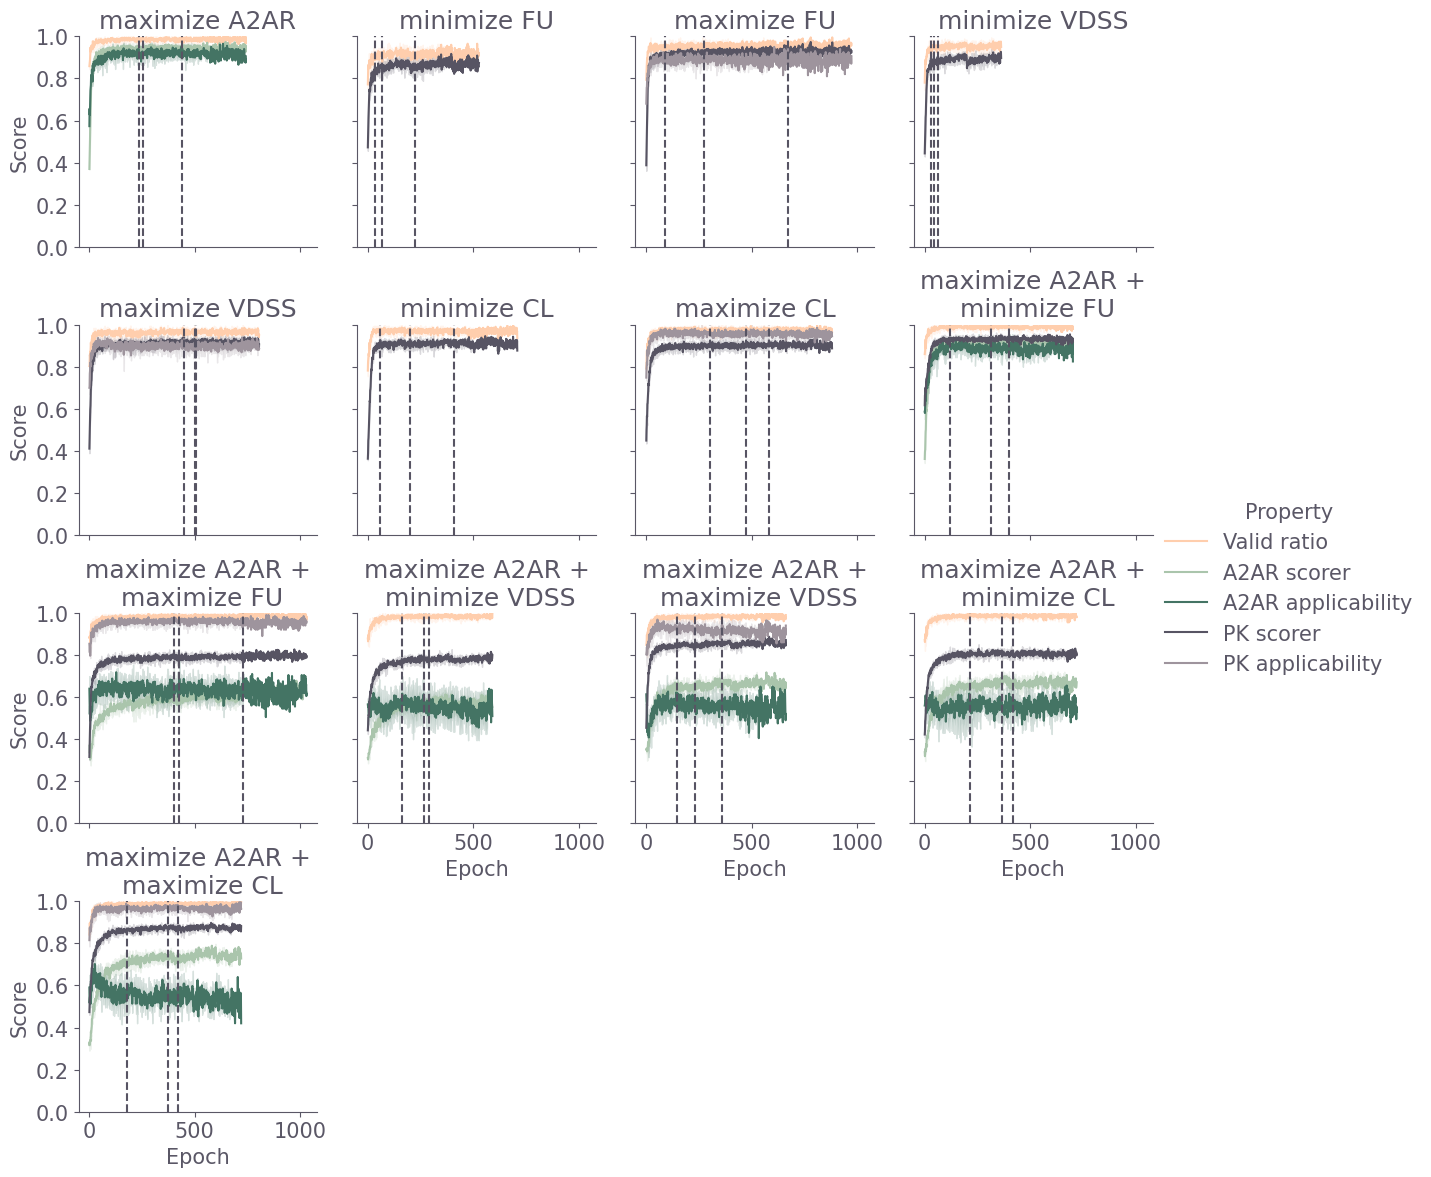

In [ ]:
#####------------------------COMBINED REINFORCEMENT FIT PLOT (Supplementary Figure S5)------------------------#####
os.makedirs(f"{FIGURES_DIR}/reinforcement_fit", exist_ok=True)

# Read reinforcement learning data
df_dict = {}
best_epochs = {}
for folder in reinforce_folders:
    scenario_name = "_".join(folder.split("_")[:-1])
    replicate = folder.split("_")[-1]
    df_smiles = pd.read_csv(f"{REINFORCE_DIR}/{folder}/{scenario_name}_agent_smiles.tsv", sep="\t")
    df_dict[(scenario_name, replicate)] = df_smiles
    df_fit = pd.read_csv(f"{REINFORCE_DIR}/{folder}/{scenario_name}_agent_fit.tsv", sep="\t")
    best_epochs[(scenario_name, replicate)] = df_fit["best_epoch"].iloc[-1]
df = pd.concat(
    df_dict, names=["Scenario", "replicate"]
).reset_index().drop(columns=["level_2", "Desired"])

# melt dataframe to long format and calculate mean scorers for each epoch
df_melted = df.melt(
    id_vars=["Scenario", "replicate", "SMILES", "Epoch"],
    var_name="Property",
    value_name="Value"
)
df_melted.dropna(inplace=True)
df_melted = df_melted.groupby(
    ["Scenario", "replicate", "Epoch", "Property"]
)["Value"].mean().reset_index()

# Rename properties to more descriptive names
property_rename_dict = {
    "A2AR_applicability_scorer": "A2AR applicability",
    "FUmax_applicability_scorer": "PK applicability",
    "VDSSmax_applicability_scorer": "PK applicability",
    "CLmax_applicability_scorer": "PK applicability",
    "A2AR_scorer": "A2AR scorer",
    "FUmin_scorer": "PK scorer",
    "FUmax_scorer": "PK scorer",
    "VDSSmin_scorer": "PK scorer",
    "VDSSmax_scorer": "PK scorer",
    "CLmin_scorer": "PK scorer",
    "CLmax_scorer": "PK scorer",
    "Valid": "Valid ratio"
}
df_melted["Property"] = df_melted["Property"].map(property_rename_dict)

# plot reinforcement learning fit
g = sns.FacetGrid(
    df_melted, col="Scenario", margin_titles=True, col_wrap=4,
    col_order=[
        "A2AR", "FUmin", "FUmax", "VDSSmin", "VDSSmax", "CLmin", "CLmax", 
        "A2AR_FUmin", "A2AR_FUmax", "A2AR_VDSSmin", "A2AR_VDSSmax", "A2AR_CLmin", "A2AR_CLmax", 
        ],
    hue="Property",
    hue_order=[
        "Valid ratio", "A2AR scorer", "A2AR applicability",
        "PK scorer", "PK applicability"
    ]
)
g.map_dataframe(sns.lineplot, x="Epoch", y="Value")

# add vertical lines at best epochs
for ax, scenario in zip(g.axes.flat, g.col_names):
    for replicate in range(3):
        best_epoch = best_epochs[(scenario, str(replicate))]
        ax.axvline(best_epoch, color=a2arcolors[3], linestyle="--")
g.set(ylim=(0, 1))
g.add_legend()
g.set_ylabels("Score")

# set titles with scenario names
for ax, title in zip(g.axes.flat, g.col_names):
    title = scenario_dict[title]
    title = title.replace("+", "+\n")
    ax.set_title(title)

plt.savefig(f"{FIGURES_DIR}/reinforcement_fit/reinforcement_fit.png", bbox_inches="tight")
plt.show()

### Generated data
Plots of the generated molecules for each scenario.
1. [General Overview](#General-Overview) Overviews of the generated molecules (validity, novelty, uniqueness, etc.) (Table 2)
2. [Internal and dataset tanimoto distance](#Internal-and-dataset-tanimoto-distance) Tanimoto similarity of the generated molecules to the training dataset and to each other. (not in manuscript)
3. [Physciochemical properties](#Physciochemical-properties) Distribution of the physicochemical properties of the generated molecules. (Figure 7)

#### General Overview

Get an overview of the generated data, including validity, uniqueness, noveltly, applicability, synthetic accessibility, and chemical diversity.
(Table 2 in manuscript)

In [ ]:
#####------------------------OVERVIEW OF GENERATED DATA (Table 2)------------------------#####
# load generated data
stats = {}
for folder in generated_folders:
    df = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000.tsv", sep="\t")
    finetuning_prop = folder.split("_")[0].removesuffix("min").removesuffix("max")
    df["min_tanimoto_dist_dataset"] = (
        df[f"min_tanimoto_dist_{finetuning_prop}"]
        if finetuning_prop != "pretrained" else None
    ) # create one column for minimum tanimoto distance to finetuning dataset
    
    stats[folder] = df.describe()
stats = pd.concat(stats, names=["Scenario"])
stats = stats.loc[
    (slice(None), "mean"), [
        "Valid", "Unique", "Novel", "Applicable", "Unique & Valid",
        "Unique & Valid & Applicable", "Unique & Valid & Applicable & Novel", "SA",
        "min_tanimoto_dist_self", "min_tanimoto_dist_dataset"
    ]
].droplevel(1)

# split index into scenario and replicate for non-pretrained or finetuned scenarios
stats["Replicate"] = stats.index.str.extract(r"_(\d+)$").values.flatten()
stats["Scenario"] = stats.index.str.replace(r"_(\d+)$", "", regex=True).values.flatten()
stats.set_index(["Scenario", "Replicate"], inplace=True, drop=True)

# rename and reorder columns
stats = stats.sort_index(level=1).loc[scenario_dict.keys()]
stats = stats.rename(
    columns={
        "SA": "Mean synthetic accessibility score",
        "min_tanimoto_dist_self": "Mean intra-dataset minimum Tanimoto distance",
        "min_tanimoto_dist_dataset": "Mean inter-dataset minimum Tanimoto distance"
    }
)
stats = stats.rename(index=scenario_dict)

# collapse generated stats into mean and std
stats_mean = stats.groupby("Scenario").mean().round(2)
stats_std = stats.groupby("Scenario").std().round(2)

# add standard deviation to mean in brackets
stats = pd.DataFrame(index=stats_mean.index, columns=stats_mean.columns)
for col in stats_mean.columns:
    # Iterate over each row
    for row in stats_mean.index:
        mean = stats_mean.at[row, col]
        std = stats_std.at[row, col]
        # Add standard deviation if it is not NaN
        if pd.notna(std):
            stats.at[row, col] = f"{mean} ({std})"
        else:
            stats.at[row, col] = f"{mean}"
stats = stats.loc[scenario_dict.values()]
stats.to_csv(f"{FIGURES_DIR}/generated_stats.csv")
stats

Valid       Unique        Novel  \
Scenario                                                                  
pretrained                               0.96         0.96          1.0   
finetuned on A2AR dataset                0.86         0.62         0.57   
maximize A2AR                      0.99 (0.0)  0.61 (0.01)   0.92 (0.0)   
finetuned on FU dataset                  0.75         0.61         0.81   
minimize FU                       0.91 (0.01)   0.9 (0.01)    1.0 (0.0)   
maximize FU                       0.95 (0.01)  0.92 (0.02)    1.0 (0.0)   
finetuned on VDSS dataset                0.76         0.67         0.85   
minimize VDSS                     0.95 (0.01)  0.83 (0.03)    1.0 (0.0)   
maximize VDSS                      0.97 (0.0)   0.95 (0.0)    1.0 (0.0)   
finetuned on CL dataset                  0.74         0.65         0.85   
minimize CL                        0.97 (0.0)  0.87 (0.05)    1.0 (0.0)   
maximize CL                        0.97 (0.0)   0.94 (0.0)    1.0 (0.0)   
finetuned on A2AR + FU dataset           0.87         0.62          0.6   
maximize A2AR + minimize FU        0.99 (0.0)  0.67 (0.02)   0.97 (0.0)   
maximize A2AR + maximize FU        0.98 (0.0)  0.64 (0.01)   0.99 (0.0)   
finetuned on A2AR + VDSS dataset         0.86         0.61         0.58   
maximize A2AR + minimize VDSS      0.98 (0.0)  0.69 (0.01)  0.98 (0.01)   
maximize A2AR + maximize VDSS      0.98 (0.0)  0.73 (0.01)   0.99 (0.0)   
finetuned on A2AR + CL dataset           0.85         0.62          0.6   
maximize A2AR + minimize CL        0.99 (0.0)  0.69 (0.02)   0.99 (0.0)   
maximize A2AR + maximize CL        0.99 (0.0)  0.62 (0.02)   0.98 (0.0)   

                                   Applicable Unique & Valid  \
Scenario                                                       
pretrained                                1.0           0.96   
finetuned on A2AR dataset                0.63           0.62   
maximize A2AR                     0.93 (0.01)    0.61 (0.01)   
finetuned on FU dataset                  0.65           0.61   
minimize FU                         1.0 (0.0)     0.9 (0.01)   
maximize FU                        0.9 (0.01)    0.92 (0.02)   
finetuned on VDSS dataset                0.68           0.67   
minimize VDSS                       1.0 (0.0)    0.83 (0.03)   
maximize VDSS                       0.9 (0.0)     0.94 (0.0)   
finetuned on CL dataset                  0.69           0.65   
minimize CL                         1.0 (0.0)    0.87 (0.05)   
maximize CL                        0.96 (0.0)     0.94 (0.0)   
finetuned on A2AR + FU dataset           0.61           0.62   
maximize A2AR + minimize FU        0.9 (0.01)    0.67 (0.02)   
maximize A2AR + maximize FU       0.66 (0.01)    0.64 (0.01)   
finetuned on A2AR + VDSS dataset         0.61           0.61   
maximize A2AR + minimize VDSS      0.6 (0.03)    0.69 (0.01)   
maximize A2AR + maximize VDSS     0.57 (0.02)    0.73 (0.01)   
finetuned on A2AR + CL dataset            0.6           0.62   
maximize A2AR + minimize CL       0.59 (0.02)    0.69 (0.02)   
maximize A2AR + maximize CL       0.58 (0.01)    0.62 (0.02)   

                                 Unique & Valid & Applicable  \
Scenario                                                       
pretrained                                              0.96   
finetuned on A2AR dataset                               0.38   
maximize A2AR                                     0.56 (0.0)   
finetuned on FU dataset                                 0.51   
minimize FU                                       0.9 (0.01)   
maximize FU                                      0.87 (0.02)   
finetuned on VDSS dataset                               0.58   
minimize VDSS                                    0.83 (0.03)   
maximize VDSS                                     0.88 (0.0)   
finetuned on CL dataset                                  0.6   
minimize CL                                      0.87 (0.05)   
maximize 

#### Physciochemical properties
Plot the distribution of the physicochemical properties of the generated molecules (Figure 7).

/tmp/ipykernel_1232039/200298368.py:42: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  g = sns.catplot(
/tmp/ipykernel_1232039/200298368.py:42: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  g = sns.catplot(
/tmp/ipykernel_1232039/200298368.py:42: UserWarning: The palette list has more values (9) than needed (7), which may not be intended.
  g = sns.catplot(


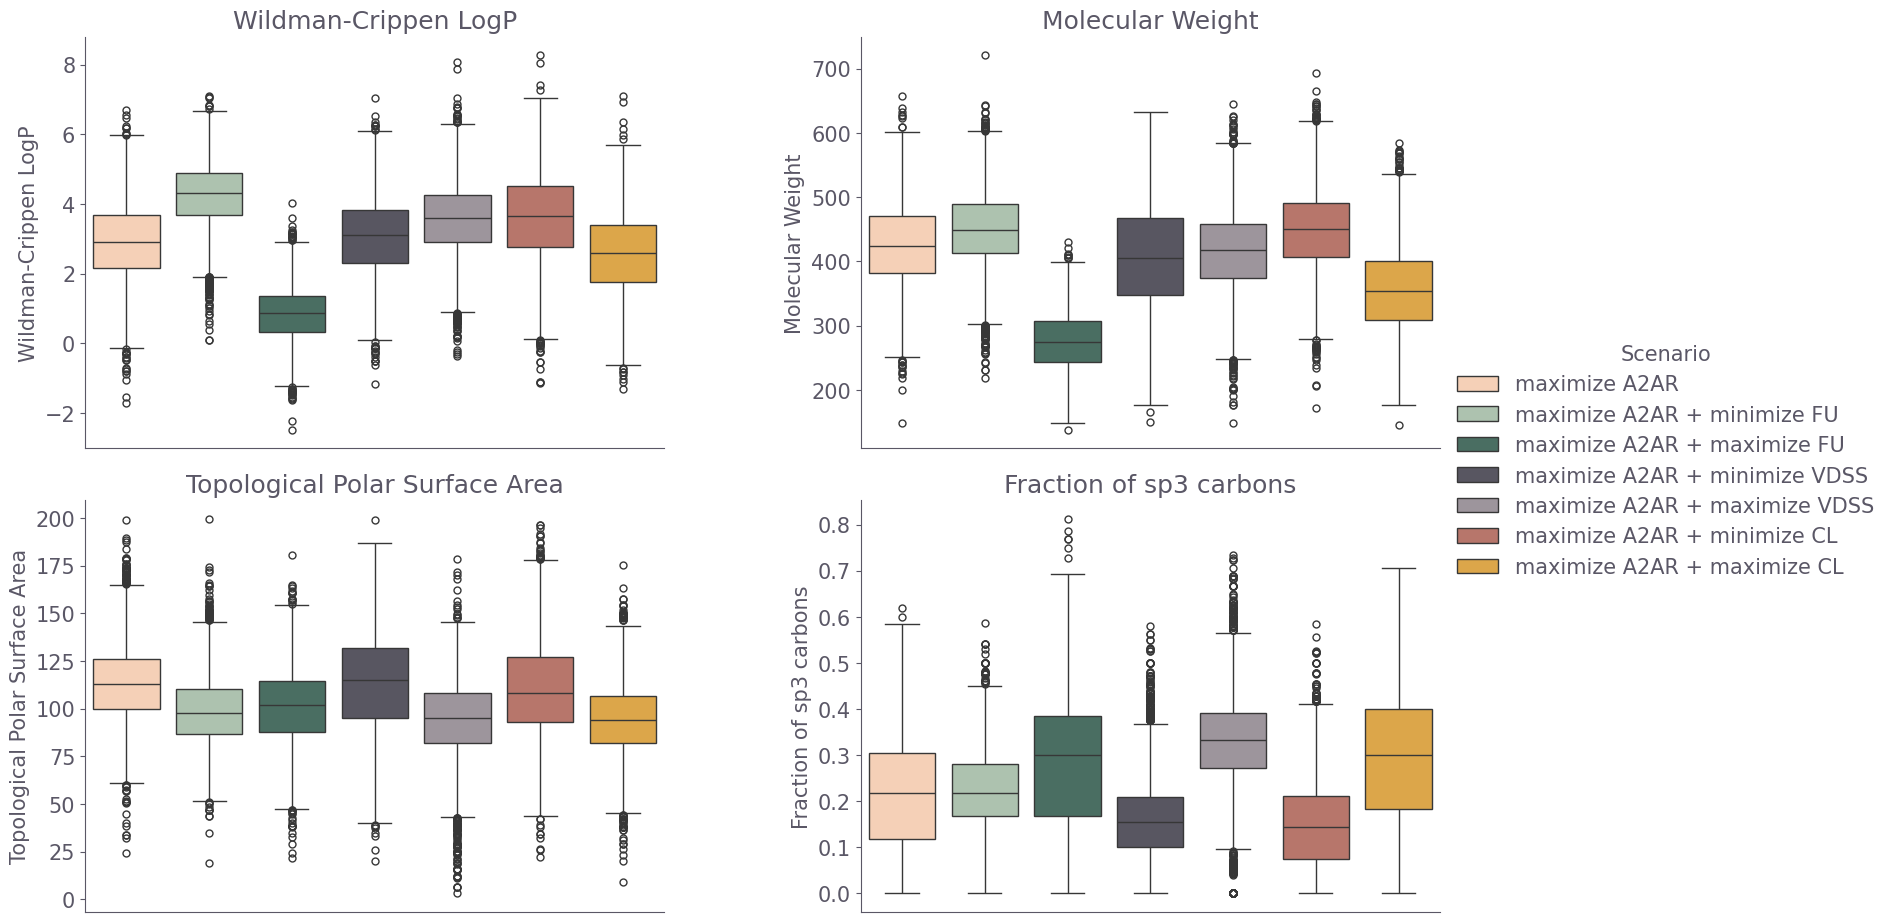

In [ ]:
#####--------------PHYSICOCHEMICAL PROPERTIES OF GENERATED DATA (Figure 7)--------------------#####
descriptors = ["MolLogP", "MolWt", "TPSA", "FractionCSP3"]
descriptor_dict = {
    "MolLogP": "Wildman-Crippen LogP",
    "MolWt": "Molecular Weight",
    "TPSA": "Topological Polar Surface Area",
    "FractionCSP3": "Fraction of sp3 carbons"
}

# plot boxplot of physchem properties for each replicate
for rep, folders in enumerate(
    [generated_folders_rep_0, generated_folders_rep_1, generated_folders_rep_2]
):
    plt.close()
    df_dict = {}
    
    # read generated data and filter for valid, applicable and novel molecules
    for folder in folders:
        df = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000.tsv", sep="\t")
        df = df[df["Unique & Valid & Applicable & Novel"] == 1]
        folder = folder.removesuffix(f"_{rep}")
        df = df[["SMILES"] + descriptors]
        df_dict[scenario_dict[folder]] = df
    df = pd.concat(df_dict.values(), keys=df_dict.keys(), names=["Scenario"])
    df = df.reset_index(level=0)

    # melt physchem dataframe to long format for plotting
    df = df.melt(
        id_vars=["SMILES", "Scenario"],
        var_name="Descriptor", 
        value_name="Value"
    )

    # replace descriptor names with more readable names
    df["Descriptor"] = df["Descriptor"].replace(descriptor_dict)

    # plot boxplot of descriptors for each scenario
    order = [
        scenario for scenario in scenario_dict.values()
        if not "finetuned" in scenario and "A2AR" in scenario
    ]
    g = sns.catplot(
        data=df, kind="box", col="Descriptor", col_wrap=2, height=5, aspect=1.5, 
        x="Scenario", y="Value", sharey=False, hue="Scenario", hue_order=order,
                order=order, legend=True, palette=a2arcolors)
    for ax in g.axes:
        ax.set_title(ax.get_title().split(" = ")[1])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")
        ax.set_ylabel(ax.get_title())
    plt.savefig(
        f"{FIGURES_DIR}/physchem_properties_{rep}.png", bbox_inches="tight", dpi=500
    )
plt.show()

#### Generated Compounds
Plot molecular structures of the generated compounds.
The centroids of the largest clusters are selected to be displayed.
Clustering was done using the LeaderPickerClusters algorithm with a tanimoto similarity threshold of 0.8 (Morgan fingerprints radius 3, size 2048).
UMAP plots of the clusters can be found in below in the [umap generated compounds](#umap-generated-compounds) section. (Figure 6)

A2AR_CLmin_1
A2AR_FUmin_0
A2AR_VDSSmax_2
A2AR_FUmax_1
A2AR_CLmax_0
A2AR_finetuned
FU_finetuned
CLmin_1
A2AR_VDSS_finetuned
FUmin_0
VDSSmax_0
FUmax_1
CLmax_0
VDSSmin_1
A2AR_VDSSmax_1
A2AR_CLmin_2
A2AR_VDSSmin_0
A2AR_FUmax_2
A2AR_0
A2AR_CL_finetuned
CLmin_2
VDSSmin_2
FUmax_2
VDSS_finetuned
FUmin_1
A2AR_2
CLmin_0
VDSSmax_1
CLmax_1
FUmax_0
VDSSmin_0
A2AR_FUmin_1
A2AR_CLmin_0
A2AR_CLmax_1
A2AR_FUmax_0
A2AR_VDSSmin_2
CL_finetuned
A2AR_FU_finetuned
VDSSmax_2
A2AR_1
FUmin_2
CLmax_2
A2AR_VDSSmax_0
A2AR_FUmin_2
A2AR_VDSSmin_1
A2AR_CLmax_2


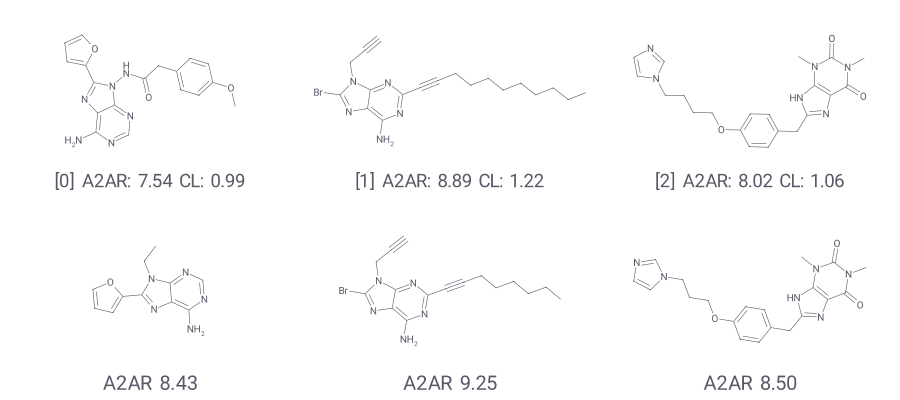

In [ ]:
#####------PLOT LARGEST CLUSTER CENTROIDS AND MOST SIMILAR DATASET COMPOUNDS (Individual molecule images Figure 6)-------#####
# set drawing options
dopts = rdMolDraw2D.MolDrawOptions()
SetACS1996Mode(dopts, 1)
COLOR_RDKIT = (0.35294117647058826, 0.3411764705882353, 0.4)
dopts.updateAtomPalette({i: COLOR_RDKIT for i in range(0, 100)})
dopts.setLegendColour(COLOR_RDKIT)
dopts.legendFontSize = 20

# set paths to QSPR datasets
QSPR_DATA_DIR = join(QSPR_DIR, "data")
prop_data_dict = {
    "A2AR": join(QSPR_DATA_DIR, config["A2AR_DATA"], f"{config['A2AR_DATA']}_meta.json"),
    "CL": join(QSPR_DATA_DIR, config["CL_DATA"], f"{config['CL_DATA']}_meta.json"),
    "VDSS": join(QSPR_DATA_DIR, config["VDSS_DATA"], f"{config['VDSS_DATA']}_meta.json"),
    "FU": join(QSPR_DATA_DIR, config["FU_DATA"], f"{config['FU_DATA']}_meta.json"),
}
NUM_CLUSTERS = 3

# Plot centroids largest clusters and most similar dataset compounds
os.makedirs(f"{FIGURES_DIR}/molecules", exist_ok=True)
for folder in generated_folders:
    if folder == "pretrained":
        continue
    try:
        print(folder)
        df = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000.tsv", sep="\t")
        df = df[df["Unique & Valid & Applicable & Novel"] == 1]
        
        # Find most similar molecule to each generated molecule in the respective dataset
        props = folder.replace("_finetuned", "").replace("min", "").replace("max", "")
        props = props.split("_")
        
        # get centroids of largest clusters in the order of largest clusters
        centroids = pd.read_csv(
            f"{GENERATED_DIR}/{folder}/generated_10000_centroids.tsv", sep="\t")
        cluster_size = df['cluster'].value_counts()
        centroids["cluster_size"] = centroids["cluster"].map(cluster_size)
        centroids = centroids.sort_values("cluster_size", ascending=False)
        centroids = centroids.head(NUM_CLUSTERS)
        
        # get centroid from df and order by largest cluster
        centroids = df[df['SMILES'].isin(centroids['SMILES'])]
        centroids = centroids.set_index("SMILES").loc[centroids["SMILES"]].reset_index()
        
        # make list of molecules to plot (centroids and most similar molecules)
        mols_to_plot = centroids["SMILES"].apply(Chem.MolFromSmiles).to_list()
        centroids[f"closest_molecule"] = centroids[f"closest_molecule_{props[0]}"]
        mols_to_plot.extend(
            centroids["closest_molecule"].apply(Chem.MolFromSmiles).to_list()
        )
        
        # add most_similar_score to centroids by merging on closest molecule
        dataset = QSPRDataset.fromFile(prop_data_dict[props[0]]).df
        df_closest = dataset[dataset["SMILES"].isin(centroids["closest_molecule"].values)].copy()
        df_closest["most_similar_score"] = (
            df_closest[props[0]].apply(lambda x: f"A2AR {x:.2f}")
        )
        centroids = centroids.merge(
            df_closest[["SMILES", "most_similar_score"]],
            left_on="closest_molecule",
            right_on="SMILES",
            suffixes=("", "_y")
        ) 
        
        # make list of legends for molecules containing property values
        scenario = folder.removesuffix("_0").removesuffix("_1").removesuffix("_2")
        scores = centroids[scenario_scorer_dict[scenario]].round(2).astype(str)
        property_names = [
            scorer_property_dict[scorer] for scorer in scenario_scorer_dict[scenario]
        ]
        scores["combined"] = scores.apply(
            lambda x: " ".join(
                [f"{property}: {score}" for property, score in zip(property_names, x)]
            ),
            axis=1
        )
        legends = scores["combined"].tolist()
        legends = [f"[{i}] {legends[i]}" for i in range(NUM_CLUSTERS)]
        legends.extend(centroids["most_similar_score"])
        
        for mol in mols_to_plot:
            Draw.PrepareMolForDrawing(mol)

        # plot molecules
        img = MolsToGridImage(
            mols_to_plot,
            molsPerRow=NUM_CLUSTERS,
            subImgSize=(300, 200),
            legends=legends,
            drawOptions=dopts,
            useSVG=True,
        )
        with open(f"{FIGURES_DIR}/molecules/{folder}.svg", "w") as f:
            f.write(img.data)
    except FileNotFoundError as e:
        print(f"Could not read {folder}")
display(img)

In [ ]:
#####---------------COMBINE PLOTS OF GENERATED MOLECULES (Figure 6)------------------------#####
for rep in range(3):
    # order image paths
    names = [
        "A2AR",
        "A2AR_FUmax", "A2AR_FUmin",
        "A2AR_VDSSmax", "A2AR_VDSSmin",
        "A2AR_CLmax", "A2AR_CLmin"
    ]
    image_paths = [f"{FIGURES_DIR}/molecules/{name}_{rep}.svg" for name in names]

    import cairosvg
    # convert svg to png
    for image_path in image_paths:
        png_path = image_path.replace(".svg", ".png")
        cairosvg.svg2png(url=image_path, write_to=png_path, scale=2)
    image_paths = [image_path.replace(".svg", ".png") for image_path in image_paths]

    # read in images
    images = [Image.open(x) for x in image_paths]

    # add a coloured border to each image
    border = 10
    for i, image in enumerate(images):
        image = image.convert("RGBA")
        
        # add white border above image
        new_image = Image.new("RGBA", (image.width, image.height + 60), "white")
        new_image.paste(image, (0, 60))
        image = new_image
        
        # add left above the image "generated" and right "dataset"
        draw = ImageDraw.Draw(image)
        draw.text(
            (15*2, 32*2),
            "Generated",
            ImageColor.getcolor(COLOR, "RGB"),
            font=ImageFont.load_default(size=20*2)
        )
        draw.text(
            (15*2, 235*2),
            "Dataset",
            ImageColor.getcolor(COLOR, "RGB"),
            font=ImageFont.load_default(size=20*2)
        )
        # add title to each image
        draw.text(
            (15*2, 0*2),
            scenario_dict[names[i]],
            ImageColor.getcolor(COLOR, "RGB"),
            font=ImageFont.load_default(size=20*2.5)
        )
        
        # add border around image
        width, height = image.size
        new_width = width + 2 * border
        new_height = height + 2 * border
        new_image = Image.new("RGBA", (new_width, new_height), a2arcolors_rgba[i])
        new_image.paste(image, (border, border))
        images[i] = new_image

    width, height = images[0].size

    # Create canvas for the final image with total size
    # shape = (len(images), 1)
    shape = (4, 2)
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    # fill background with white
    draw = ImageDraw.Draw(image)
    draw.rectangle(xy=[(0, 0), image_size], fill="white")

    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            # leave second image space empty
            if idx == 0:
                image.paste(images[idx], offset)
            elif idx == 1:
                continue
            else:
                image.paste(images[idx-1], offset)

    image.save(f'{FIGURES_DIR}/molecules/molecules_combined_{rep}.png')

#### Score distribution
Plot the distribution of the scores of the generated molecules (Figure 4 and Supplementary Figure S6).
This gives an indication of how well the model has learned to generate molecules with the desired properties.

Replicate 0
Name: A2AR, combination: ('A2AR', 'A2AR_finetuned')


mean   std
scenario                  scorer            
finetuned on A2AR dataset A2AR    6.62  0.86
maximize A2AR             A2AR    8.76  0.51

Name: FU, combination: ('FUmin', 'FU_finetuned', 'FUmax')


mean   std
scenario                scorer            
finetuned on FU dataset FU      0.45  0.21
maximize FU             FU      1.01  0.11
minimize FU             FU      0.10  0.15

Name: VDSS, combination: ('VDSSmin', 'VDSS_finetuned', 'VDSSmax')


mean   std
scenario                  scorer            
finetuned on VDSS dataset VDSS    0.08  0.35
maximize VDSS             VDSS    0.96  0.19
minimize VDSS             VDSS   -0.66  0.29

Name: CL, combination: ('CLmin', 'CL_finetuned', 'CLmax')


mean   std
scenario                scorer            
finetuned on CL dataset CL      0.68  0.28
maximize CL             CL      1.31  0.23
minimize CL             CL     -0.14  0.25

Name: A2AR_FU, combination: ('A2AR_FUmin', 'A2AR_FU_finetuned', 'A2AR_FUmax')


mean   std
scenario                       scorer            
finetuned on A2AR + FU dataset A2AR    6.59  0.85
                               FU      0.34  0.18
maximize A2AR + maximize FU    A2AR    7.49  0.61
                               FU      0.77  0.10
maximize A2AR + minimize FU    A2AR    8.52  0.46
                               FU      0.10  0.12

Name: A2AR_VDSS, combination: ('A2AR_VDSSmin', 'A2AR_VDSS_finetuned', 'A2AR_VDSSmax')


mean   std
scenario                         scorer            
finetuned on A2AR + VDSS dataset A2AR    6.55  0.84
                                 VDSS    0.14  0.22
maximize A2AR + maximize VDSS    A2AR    7.61  0.73
                                 VDSS    0.69  0.17
maximize A2AR + minimize VDSS    A2AR    7.30  0.79
                                 VDSS   -0.33  0.21

Name: A2AR_CL, combination: ('A2AR_CLmin', 'A2AR_CL_finetuned', 'A2AR_CLmax')


mean   std
scenario                       scorer            
finetuned on A2AR + CL dataset A2AR    6.60  0.83
                               CL      0.68  0.23
maximize A2AR + maximize CL    A2AR    7.65  0.68
                               CL      1.11  0.18
maximize A2AR + minimize CL    A2AR    7.49  0.73
                               CL      0.19  0.18

Replicate 1
Name: A2AR, combination: ('A2AR', 'A2AR_finetuned')


mean   std
scenario                  scorer            
finetuned on A2AR dataset A2AR    6.62  0.86
maximize A2AR             A2AR    8.72  0.49

Name: FU, combination: ('FUmin', 'FU_finetuned', 'FUmax')


mean   std
scenario                scorer            
finetuned on FU dataset FU      0.45  0.21
maximize FU             FU      1.01  0.11
minimize FU             FU      0.07  0.14

Name: VDSS, combination: ('VDSSmin', 'VDSS_finetuned', 'VDSSmax')


mean   std
scenario                  scorer            
finetuned on VDSS dataset VDSS    0.08  0.35
maximize VDSS             VDSS    0.95  0.19
minimize VDSS             VDSS   -0.70  0.28

Name: CL, combination: ('CLmin', 'CL_finetuned', 'CLmax')


mean   std
scenario                scorer            
finetuned on CL dataset CL      0.68  0.28
maximize CL             CL      1.33  0.22
minimize CL             CL     -0.15  0.25

Name: A2AR_FU, combination: ('A2AR_FUmin', 'A2AR_FU_finetuned', 'A2AR_FUmax')


mean   std
scenario                       scorer            
finetuned on A2AR + FU dataset A2AR    6.59  0.85
                               FU      0.34  0.18
maximize A2AR + maximize FU    A2AR    7.32  0.70
                               FU      0.76  0.11
maximize A2AR + minimize FU    A2AR    8.45  0.55
                               FU      0.12  0.14

Name: A2AR_VDSS, combination: ('A2AR_VDSSmin', 'A2AR_VDSS_finetuned', 'A2AR_VDSSmax')


mean   std
scenario                         scorer            
finetuned on A2AR + VDSS dataset A2AR    6.55  0.84
                                 VDSS    0.14  0.22
maximize A2AR + maximize VDSS    A2AR    7.51  0.76
                                 VDSS    0.69  0.17
maximize A2AR + minimize VDSS    A2AR    7.23  0.77
                                 VDSS   -0.32  0.22

Name: A2AR_CL, combination: ('A2AR_CLmin', 'A2AR_CL_finetuned', 'A2AR_CLmax')


mean   std
scenario                       scorer            
finetuned on A2AR + CL dataset A2AR    6.60  0.83
                               CL      0.68  0.23
maximize A2AR + maximize CL    A2AR    7.59  0.67
                               CL      1.11  0.17
maximize A2AR + minimize CL    A2AR    7.57  0.75
                               CL      0.17  0.18

Replicate 2
Name: A2AR, combination: ('A2AR', 'A2AR_finetuned')


mean   std
scenario                  scorer            
finetuned on A2AR dataset A2AR    6.62  0.86
maximize A2AR             A2AR    8.70  0.50

Name: FU, combination: ('FUmin', 'FU_finetuned', 'FUmax')


mean   std
scenario                scorer            
finetuned on FU dataset FU      0.45  0.21
maximize FU             FU      0.99  0.11
minimize FU             FU      0.11  0.15

Name: VDSS, combination: ('VDSSmin', 'VDSS_finetuned', 'VDSSmax')


mean   std
scenario                  scorer            
finetuned on VDSS dataset VDSS    0.08  0.35
maximize VDSS             VDSS    0.95  0.20
minimize VDSS             VDSS   -0.68  0.29

Name: CL, combination: ('CLmin', 'CL_finetuned', 'CLmax')


mean   std
scenario                scorer            
finetuned on CL dataset CL      0.68  0.28
maximize CL             CL      1.31  0.23
minimize CL             CL     -0.11  0.26

Name: A2AR_FU, combination: ('A2AR_FUmin', 'A2AR_FU_finetuned', 'A2AR_FUmax')


mean   std
scenario                       scorer            
finetuned on A2AR + FU dataset A2AR    6.59  0.85
                               FU      0.34  0.18
maximize A2AR + maximize FU    A2AR    7.30  0.68
                               FU      0.77  0.10
maximize A2AR + minimize FU    A2AR    8.49  0.49
                               FU      0.11  0.13

Name: A2AR_VDSS, combination: ('A2AR_VDSSmin', 'A2AR_VDSS_finetuned', 'A2AR_VDSSmax')


mean   std
scenario                         scorer            
finetuned on A2AR + VDSS dataset A2AR    6.55  0.84
                                 VDSS    0.14  0.22
maximize A2AR + maximize VDSS    A2AR    7.66  0.73
                                 VDSS    0.70  0.17
maximize A2AR + minimize VDSS    A2AR    7.39  0.70
                                 VDSS   -0.36  0.20

Name: A2AR_CL, combination: ('A2AR_CLmin', 'A2AR_CL_finetuned', 'A2AR_CLmax')


mean   std
scenario                       scorer            
finetuned on A2AR + CL dataset A2AR    6.60  0.83
                               CL      0.68  0.23
maximize A2AR + maximize CL    A2AR    7.56  0.69
                               CL      1.12  0.16
maximize A2AR + minimize CL    A2AR    7.60  0.69
                               CL      0.20  0.19

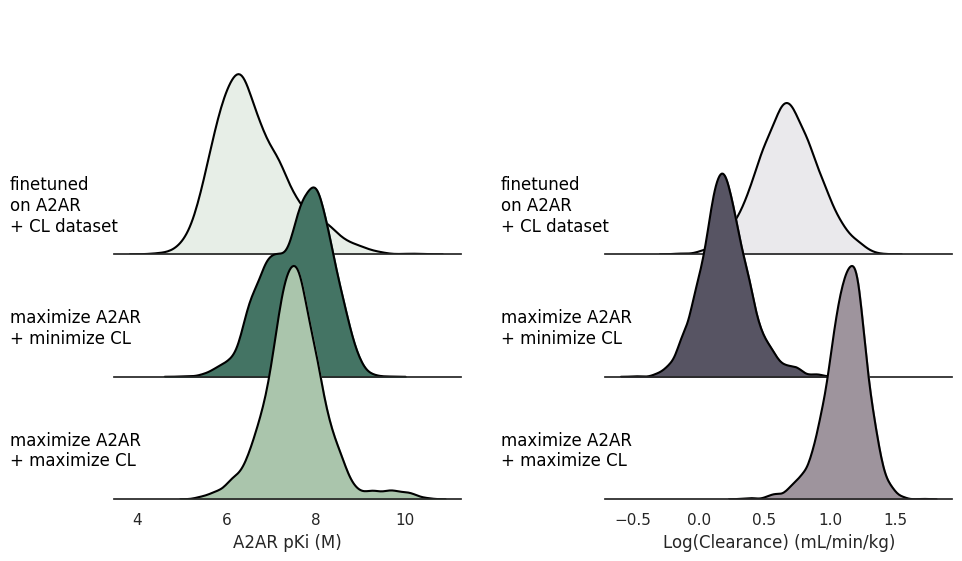

In [ ]:
#####---------------------SINGLE OBJECTIVE DENSITY PLOTS (Individual plots for Figure 4 and Supplementary Figure S6)---------------------#####
os.makedirs(f"{FIGURES_DIR}/density", exist_ok=True)

scorer_dict = {
    "A2AR": "A2AR_scorer",
    "CL": "CLmax_scorer",
    "FU": "FUmax_scorer",
    "VDSS": "VDSSmax_scorer",
}

app_scorer_dict = {
    "A2AR": "A2AR_applicability_scorer",
    "CL": "CL_applicability_scorer",
    "FU": "FU_applicability_scorer",
    "VDSS": "VDSS_applicability_scorer",
}

custom_colors = ["#E7EEE7", a2arcolors[2], a2arcolors[1], "#EAE9EC",  a2arcolors[3], a2arcolors[4]]

for rep, folders in enumerate(
    [generated_folders_rep_0, generated_folders_rep_1, generated_folders_rep_2]
):
    print(f"Replicate {rep}")
    plt.close()
    os.makedirs(f"{FIGURES_DIR}/density/{rep}", exist_ok=True)
    
    # read generated compound data
    df_reinforce_list = []
    for folder in folders:
        df_reinforce = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000.tsv", sep="\t")
        df_reinforce["scenario"] = folder.removesuffix("_0").removesuffix("_1").removesuffix("_2")
        df_reinforce = df_reinforce[df_reinforce["Unique & Valid & Applicable & Novel"] == 1]
        df_reinforce_list.append(df_reinforce)
    df_reinforce = pd.concat(df_reinforce_list, ignore_index=True)
        
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
    for name, combination in combinations_dict.items():
        print(f"Name: {name}, combination: {combination}")
        plt.close()
        df_combination = df_reinforce[df_reinforce["scenario"].isin(combination)]
        objectives = name.split("_")
        scorers = [scorer_dict[objective] for objective in objectives]
        df_combination = df_combination[["SMILES", "scenario", *scorers]]

        # rename scorers to objective names
        df_combination.columns = ["SMILES", "scenario", *objectives]
        df_combination = df_combination.melt(
            id_vars=["SMILES", "scenario"], var_name="scorer", value_name="score"
        )
        df_combination["scorer"] = df_combination["scorer"].replace(
            {scorer_dict[objective]: objective for objective in objectives}
        )

        # rename scenario to scenario name
        df_combination["scenario"] = df_combination["scenario"].replace(scenario_dict)
        
        # hue order is finetuned, min, max
        row_order = [
            "finetuned on A2AR dataset", "finetuned on A2AR + FU dataset",
            "finetuned on A2AR + VDSS dataset", "finetuned on A2AR + CL dataset",
            "finetuned on FU dataset", "finetuned on VDSS dataset",
            "finetuned on CL dataset",  "maximize A2AR",
            "minimize FU", "maximize FU", "minimize VDSS", "maximize VDSS",
            "minimize CL", "maximize CL",
            "maximize A2AR + minimize FU", "maximize A2AR + maximize FU",
            "maximize A2AR + minimize VDSS", "maximize A2AR + maximize VDSS",
            "maximize A2AR + minimize CL", "maximize A2AR + maximize CL",
        ]
        row_order = [hue for hue in row_order if hue in df_combination["scenario"].unique()]
        
        df_combination["hue"] = df_combination[['scenario', 'scorer']].apply(tuple, axis=1)
        hue_order = [
            (hue, scorer) for scorer in objectives for hue in row_order
        ]
        selected_colors = custom_colors[-3:] if not "A2AR" in objectives else custom_colors
        
        # print mean and std of scores
        display(
            df_combination.groupby(["scenario", "scorer"])["score"].agg(["mean", "std"]).round(2)
        )
        
        # make density plot facetted by scorer
        g = sns.FacetGrid(
            df_combination, row='scenario', col="scorer", sharex="col", sharey="col",
            hue="hue", palette=selected_colors, height=2, aspect=2.5,
            row_order=row_order, hue_order=hue_order
        )
        g.map_dataframe(sns.kdeplot, x="score", fill=True, alpha=1)
        g.map_dataframe(sns.kdeplot, x="score", color='black')
        def label(x, color, label):
            ax = plt.gca()
            label = label.split("',")[0].replace("('", "")
            # insert line break after ' + ' and ' on' in label
            label = label.replace(" + ", "\n+ ").replace(" on", "\non")
            ax.text(-0.3, .2, label, color='black', fontsize=12,
                    ha="left", va="center", transform=ax.transAxes)

        g.map(label, "scenario")
        
        g.fig.subplots_adjust(hspace=-.5)

        for ax in g.axes.flat:
            ax.set_xlabel(property_name_dict[ax.get_title().split("= ")[-1]])
            ax.set_ylabel("")
            ax.set_title("")
            ax.set_yticks([])
        
        g.despine(left=True)
        plt.savefig(f"{FIGURES_DIR}/density/{rep}/{name}.png", bbox_inches="tight", dpi=300)
plt.show()
        
set_theme() # reset theme
    

In [ ]:
#####-------------COMBINE SINGLE OBJECTIVE DENSITY PLOTS INTO ONE (Figure 4 and Supplementary Figure S6)---------------------#####
def combine_images(image_paths, n_cols=2, suffix=""):
        images = [Image.open(x) for x in image_paths]

        # add subplot character (A, B, C, D, E)
        for idx, image in enumerate(images):
            draw = ImageDraw.Draw(image)
            draw.text((15, 15), chr(65 + idx), ImageColor.getcolor(COLOR, "RGB"), font=ImageFont.load_default(size=200))

        width, height = images[1].size

        # Create canvas for the final image with total size
        shape = (len(images) // n_cols, n_cols)
        image_size = (width * shape[1], height * shape[0])
        image = Image.new('RGB', image_size)
        # fill background with white
        draw = ImageDraw.Draw(image)
        draw.rectangle(xy=[(0, 0), image_size], fill="white")

        # Paste images into final image
        for row in range(shape[0]):
            for col in range(shape[1]):
                offset = width * col, height * row
                idx = row * shape[1] + col
                image.paste(images[idx], offset)
        image.save(f'{FIGURES_DIR}/density/combined_density_{suffix}.png', dpi=(300, 300))

for rep in range(3):
    image_path_A2AR = f"{FIGURES_DIR}/density/{rep}/A2AR.png"
    image_path_A2AR_FU = f"{FIGURES_DIR}/density/{rep}/A2AR_FU.png"
    image_path_A2AR_VDSS = f"{FIGURES_DIR}/density/{rep}/A2AR_VDSS.png"
    image_path_A2AR_CL = f"{FIGURES_DIR}/density/{rep}/A2AR_CL.png"
    image_paths = [image_path_A2AR, image_path_A2AR_FU, image_path_A2AR_VDSS, image_path_A2AR_CL]
    combine_images(image_paths, n_cols=2, suffix=f"{rep}_multi")

    image_path_FU = f"{FIGURES_DIR}/density/{rep}/FU.png"
    image_path_VDSS = f"{FIGURES_DIR}/density/{rep}/VDSS.png"
    image_path_CL = f"{FIGURES_DIR}/density/{rep}/CL.png"
    image_paths = [image_path_FU, image_path_VDSS, image_path_CL]
    combine_images(image_paths, n_cols=3, suffix=f"{rep}_single")


#### umap generated compounds
Plot UMAPs of the generated compounds.
1. UMAP of the generated compounds colored by the scores of the combined objectives (A2AR + PK) and the A2AR objective. (Figure 5)
2. UMAP of the generated compounds colored by the scores of the PK objective. (Supplementary Figure S7)

For the plot of the A2AR (+ PK) objective, one UMAP was made of all the generated compounds
 in the finetuning dataset and the compounds generated from the finetuned and reinforced models.

For the plot of the PK objective, one UMAP was made of all the generated compounds per objective
 in the finetuning dataset and the compounds generated from the finetuned and reinforced models.

In [ ]:
#####-----------------------------READ IN UMAP DATA--------------------------------#####
df_dict = {}
centroids_dict = {}
rep = 0
for folder in generated_folders_reinforced:
    if not f"_{rep}" in folder or "finetuned" in folder:
        continue
    print(folder)
    # read in generated compounds from reinforcement learning
    df = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000.tsv", sep="\t")
    df_centroids = pd.read_csv(f"{GENERATED_DIR}/{folder}/generated_10000_centroids.tsv", sep="\t")
    folder = folder.removesuffix(f"_{rep}")
    df["source"] = folder
    # get finetuned generated compounds
    finetuned_props = folder.replace("min", "").replace("max", "")
    df_finetuned = pd.read_csv(f"{GENERATED_DIR}/{finetuned_props}_finetuned/generated_10000.tsv", sep="\t")
    df_finetuned["source"] = "finetuned"
    # read in finetuning dataset
    df_train = pd.read_csv(f"{DNDD_DIR}/finetuned/{finetuned_props}/train_df.tsv", sep="\t")
    df_train["source"] = "dataset"
    # concatenate all dataframes
    df = pd.concat([df, df_finetuned, df_train], ignore_index=True).reset_index(drop=True)
    df["UMAP1"] = df[f"UMAP1_{rep}"]
    df["UMAP2"] = df[f"UMAP2_{rep}"]
    df_dict[folder] = df
    # read in centroids of clustered reinforcement learning compounds
    cluster_counts = df["cluster"].value_counts()
    # add cluster counts to centroids
    df_centroids["cluster_count"] = df_centroids["cluster"].map(cluster_counts)
    df_centroids.sort_values("cluster_count", ascending=False, inplace=True)
    
    centroids_dict[folder] = df_centroids.reset_index(drop=True)

A2AR_FUmin_0
A2AR_CLmax_0
FUmin_0
VDSSmax_0
CLmax_0
A2AR_VDSSmin_0
A2AR_0
CLmin_0
FUmax_0
VDSSmin_0
A2AR_CLmin_0
A2AR_FUmax_0
A2AR_VDSSmax_0


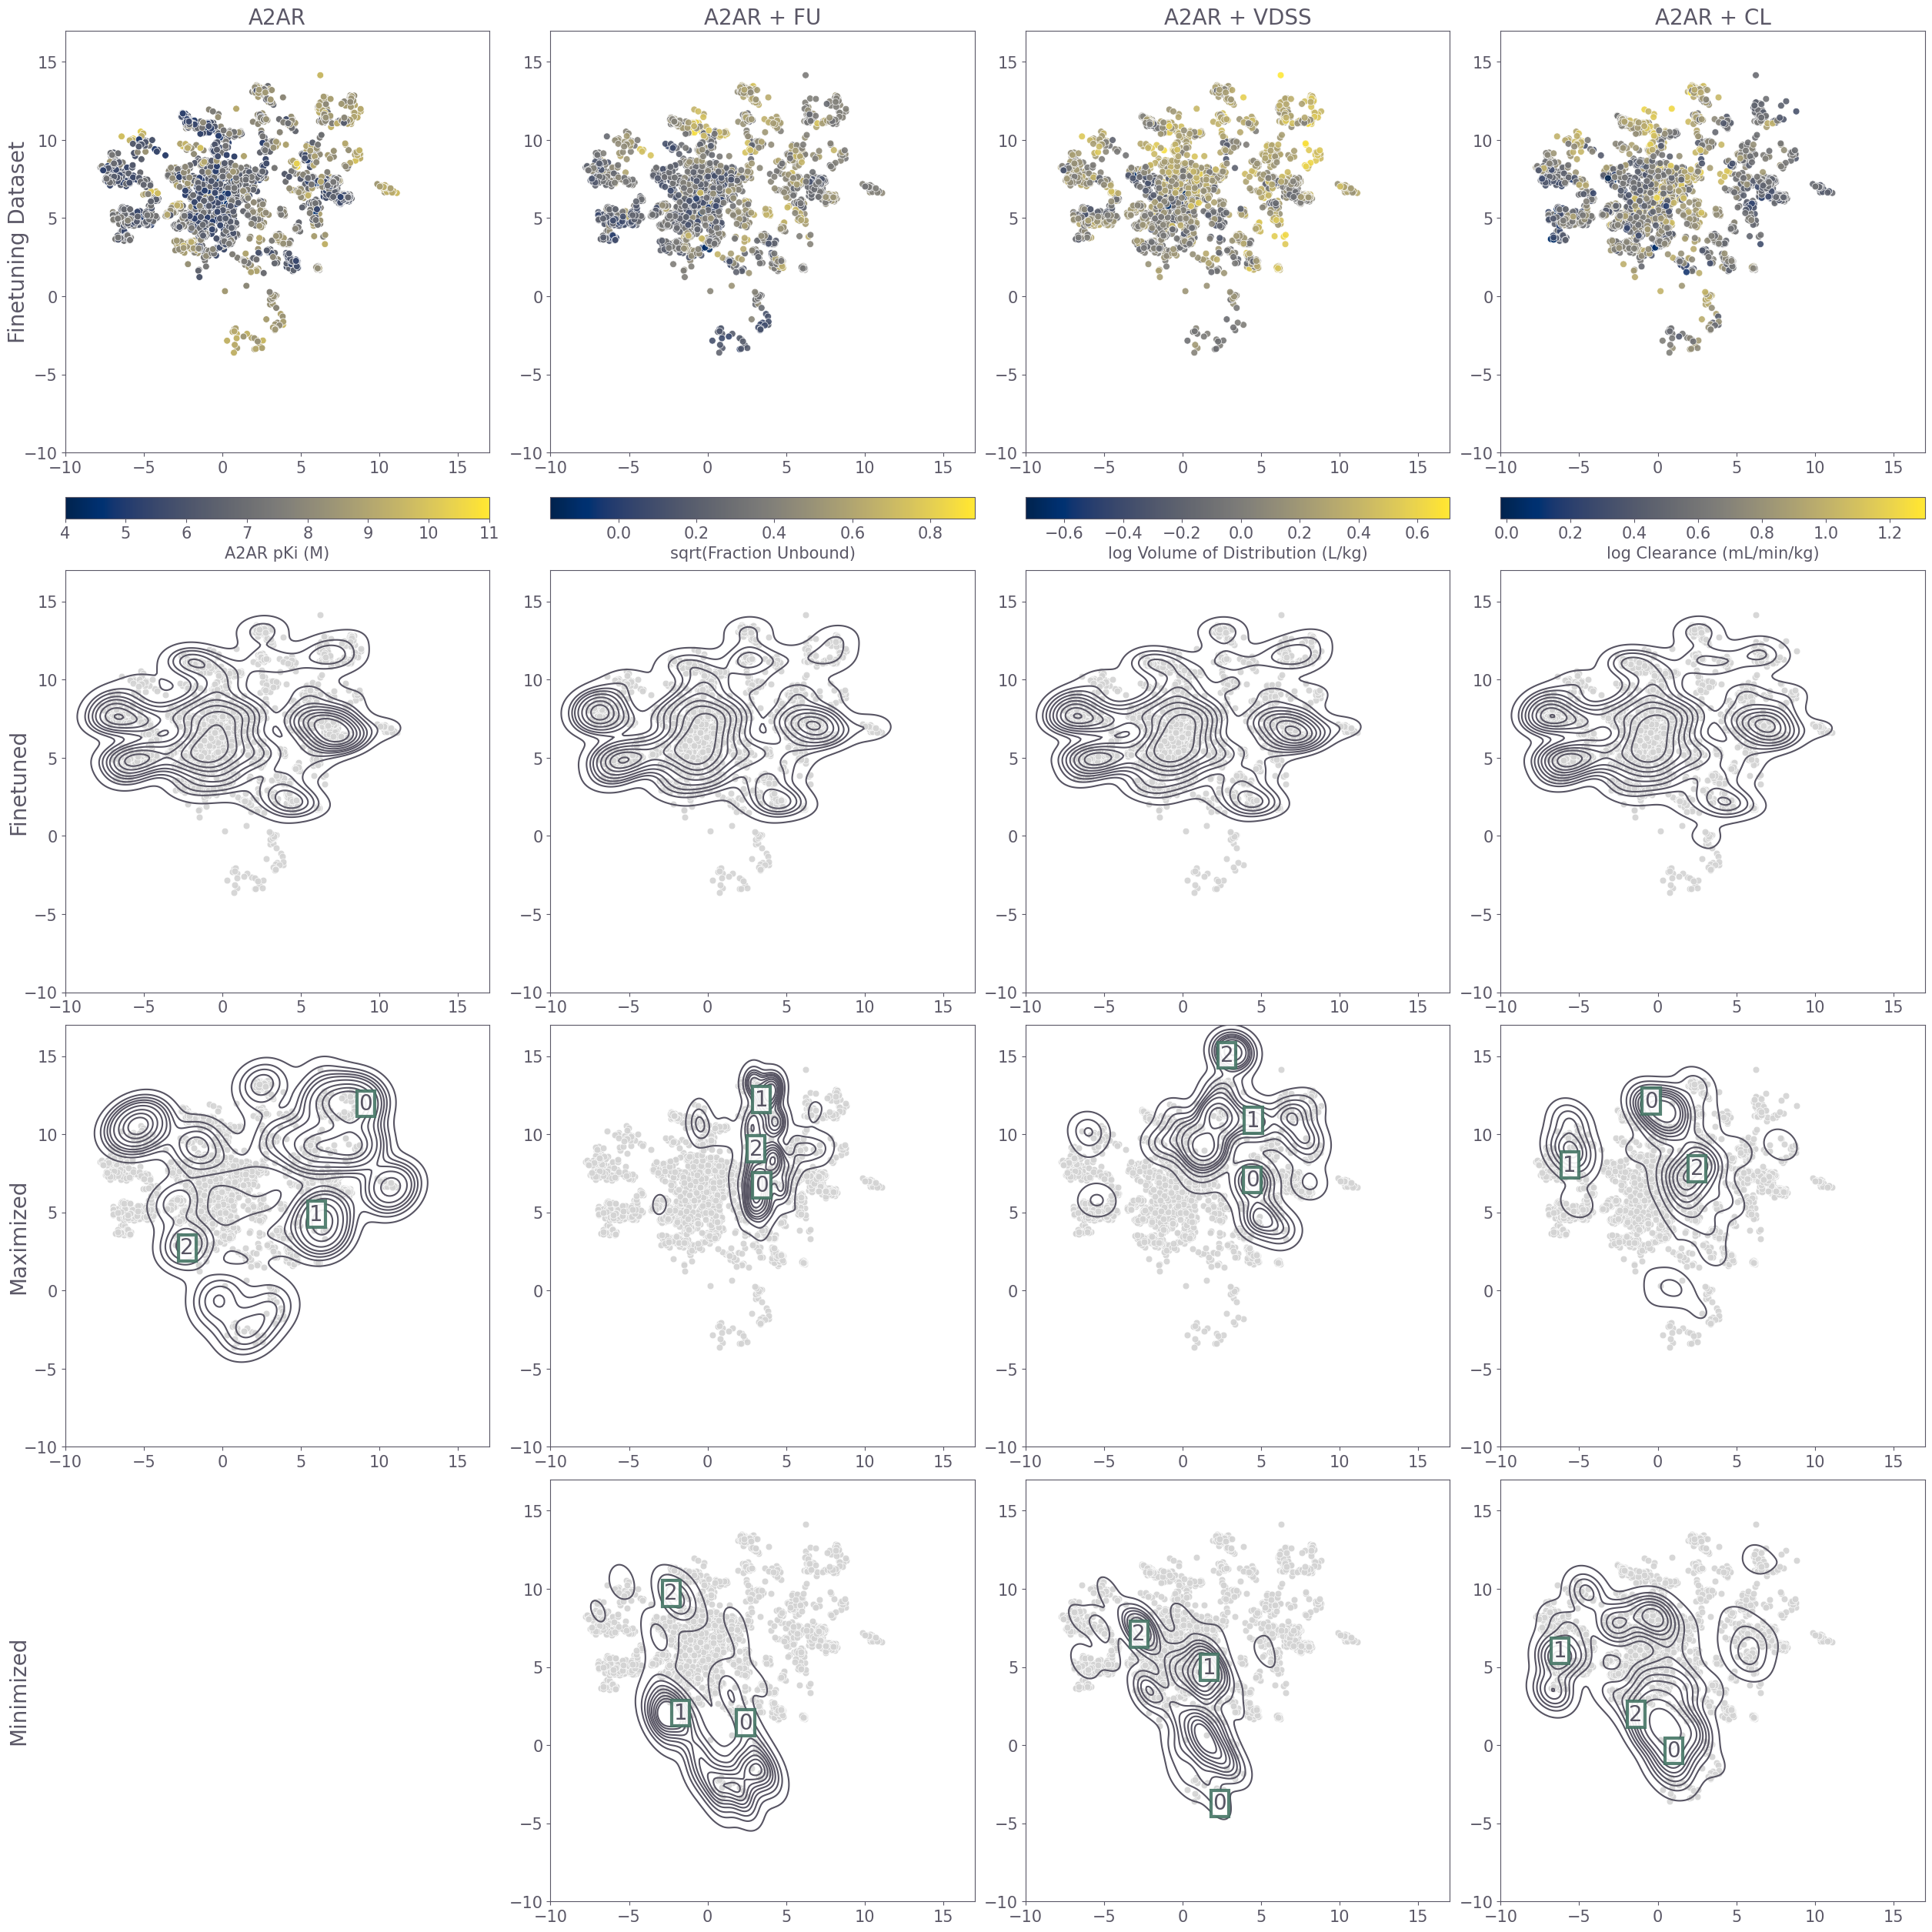

In [ ]:
#####------------------UMAP PLOTS OF A2AR AND PK PROPERTIES (Figure 5)------------------------#####
os.makedirs(f"{FIGURES_DIR}/umap", exist_ok=True)

label_dict = {"A2AR": "A2AR pKi (M)",
              "CL": "log Clearance (mL/min/kg)",
              "CL_pred": "log Clearance (mL/min/kg)",
              "FU": "sqrt Fraction Unbound",
              "FU_pred": "sqrt Fraction Unbound",
              "VDSS": "log Volume of Distribution (L/kg)",
              "VDSS_pred": "log Volume of Distribution (L/kg)"}

NUM_CLUSTERS = 3
POINT_SIZE = 40
POINT_COLOR = a2arcolors[3]

plt.close()
# make plot with UMAP for each combination
fig, ax = plt.subplots(4, 4, figsize=(25, 25), layout="constrained")

## plot column for A2AR
df = df_dict["A2AR"]
ax[0,0].set_title("A2AR", size=20)
# plot dataset coloured by pchembl value
norm = mpl.colors.Normalize(vmin=df["A2AR"].min(), vmax=df["A2AR"].max(), clip=True)
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,0], hue="A2AR_pred", s=POINT_SIZE, palette='cividis', hue_norm=norm)
# normalize on 10/90 percentile
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
# add horizontal colorbar
fig.colorbar(sm, ax=ax[0,0], label="A2AR pKi (M)", orientation="horizontal")
ax[0,0].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,0], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,0], color=POINT_COLOR)
# plot maximized A2AR overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,0], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR"], x="UMAP1", y="UMAP2", ax=ax[2,0], color=POINT_COLOR)

## plot column for FU
df = df_dict["A2AR_FUmax"]
ax[0,1].set_title("A2AR + FU", size=20)
# plot dataset coloured by FU value
norm = mpl.colors.Normalize(vmin=df["FU_pred"].min(), vmax=df["FU_pred"].max(), clip=True)
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,1], hue="FU_pred", s=POINT_SIZE, alpha=0.9, palette='cividis', hue_norm=norm)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,1], label="sqrt(Fraction Unbound)", orientation="horizontal")
ax[0,1].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,1], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,1], color=POINT_COLOR)
# plot maximized FU overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,1], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_FUmax"], x="UMAP1", y="UMAP2", ax=ax[2,1], color=POINT_COLOR)
# plot minimized FU overlaying dataset
df = df_dict["A2AR_FUmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,1], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_FUmin"], x="UMAP1", y="UMAP2", ax=ax[3,1], color=POINT_COLOR)

## plot column for VDSS
df = df_dict["A2AR_VDSSmax"]
ax[0,2].set_title("A2AR + VDSS", size=20)
# plot dataset coloured by VDSS value
norm = mpl.colors.Normalize(vmin=df["VDSS_pred"].min(), vmax=df["VDSS_pred"].max(), clip=True)
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,2], hue="VDSS_pred", s=POINT_SIZE, alpha=0.9, palette='cividis', hue_norm=norm)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,2], label="log Volume of Distribution (L/kg)", orientation="horizontal")
ax[0,2].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,2], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,2], color=POINT_COLOR)
# plot maximized VDSS overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,2], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_VDSSmax"], x="UMAP1", y="UMAP2", ax=ax[2,2], color=POINT_COLOR)
# plot minimized VDSS overlaying dataset
df = df_dict["A2AR_VDSSmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,2], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_VDSSmin"], x="UMAP1", y="UMAP2", ax=ax[3,2], color=POINT_COLOR)

## plot column for CL
df = df_dict["A2AR_CLmax"]
ax[0,3].set_title("A2AR + CL", size=20)
# plot dataset coloured by CL value
norm = mpl.colors.Normalize(vmin=df["CL_pred"].min(), vmax=df["CL_pred"].max(), clip=True)
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,3], hue="CL_pred", s=POINT_SIZE, alpha=0.9, palette='cividis', hue_norm=norm)
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,3], label="log Clearance (mL/min/kg)", orientation="horizontal")
ax[0,3].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,3], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,3], color=POINT_COLOR)
# plot maximized CL overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,3], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_CLmax"], x="UMAP1", y="UMAP2", ax=ax[2,3], color=POINT_COLOR)
# plot minimized CL overlaying dataset
df = df_dict["A2AR_CLmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,3], s=POINT_SIZE, alpha=0.9, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "A2AR_CLmin"], x="UMAP1", y="UMAP2", ax=ax[3,3], color=POINT_COLOR)


# add labels to the cluster centroids
for prop_ax, prop in zip(
    [ax[2,0], ax[2,1], ax[3,1], ax[2,2], ax[3,2], ax[2,3], ax[3,3]],
    ["A2AR", "A2AR_FUmax", "A2AR_FUmin", "A2AR_VDSSmax", "A2AR_VDSSmin", "A2AR_CLmax", "A2AR_CLmin"]
):
    df = df_dict[prop]
    centroids = centroids_dict[prop]
    for cluster, centroid in centroids[:NUM_CLUSTERS].SMILES.items():
        cluster_center = df[df["SMILES"] == centroid]
        prop_ax.text(
            cluster_center["UMAP1"].iloc[0], cluster_center["UMAP2"].iloc[0],
            cluster, fontsize=20,
            bbox=dict(facecolor='white', alpha=0.9, pad=2, edgecolor=a2arcolors[2], linewidth=3),
            ha='center', va='center', color=a2arcolors[3]
        )

# set ylim and xlim for each facet
for i in range(4):
    for j in range(4):
        ax[i,j].set_xlim(-10, 17)
        ax[i,j].set_ylim(-10, 17)
        # remove x and y labels
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")

# add labels to the left of the first column
for r, ax1 in zip(["Finetuning Dataset", "Finetuned", "Maximized", "Minimized"], ax[:, 0]):
    ax2 = ax1.twinx()
    # move extra axis to the left, with offset
    ax2.yaxis.set_label_position('left')
    ax2.spines['left'].set_position(('axes', -0.1))
    # hide spines and ticks, set group label
    ax2.spines[['left', 'top', 'bottom', 'right']].set_visible(False)
    ax2.set_yticks([])
    ax2.set_ylabel(r, rotation=90, size=20,
                   ha='center', va='center')

fig.delaxes(ax[3,0])
plt.savefig(f"{FIGURES_DIR}/umap/umap_combined.png", bbox_inches="tight", dpi=500)
plt.show()

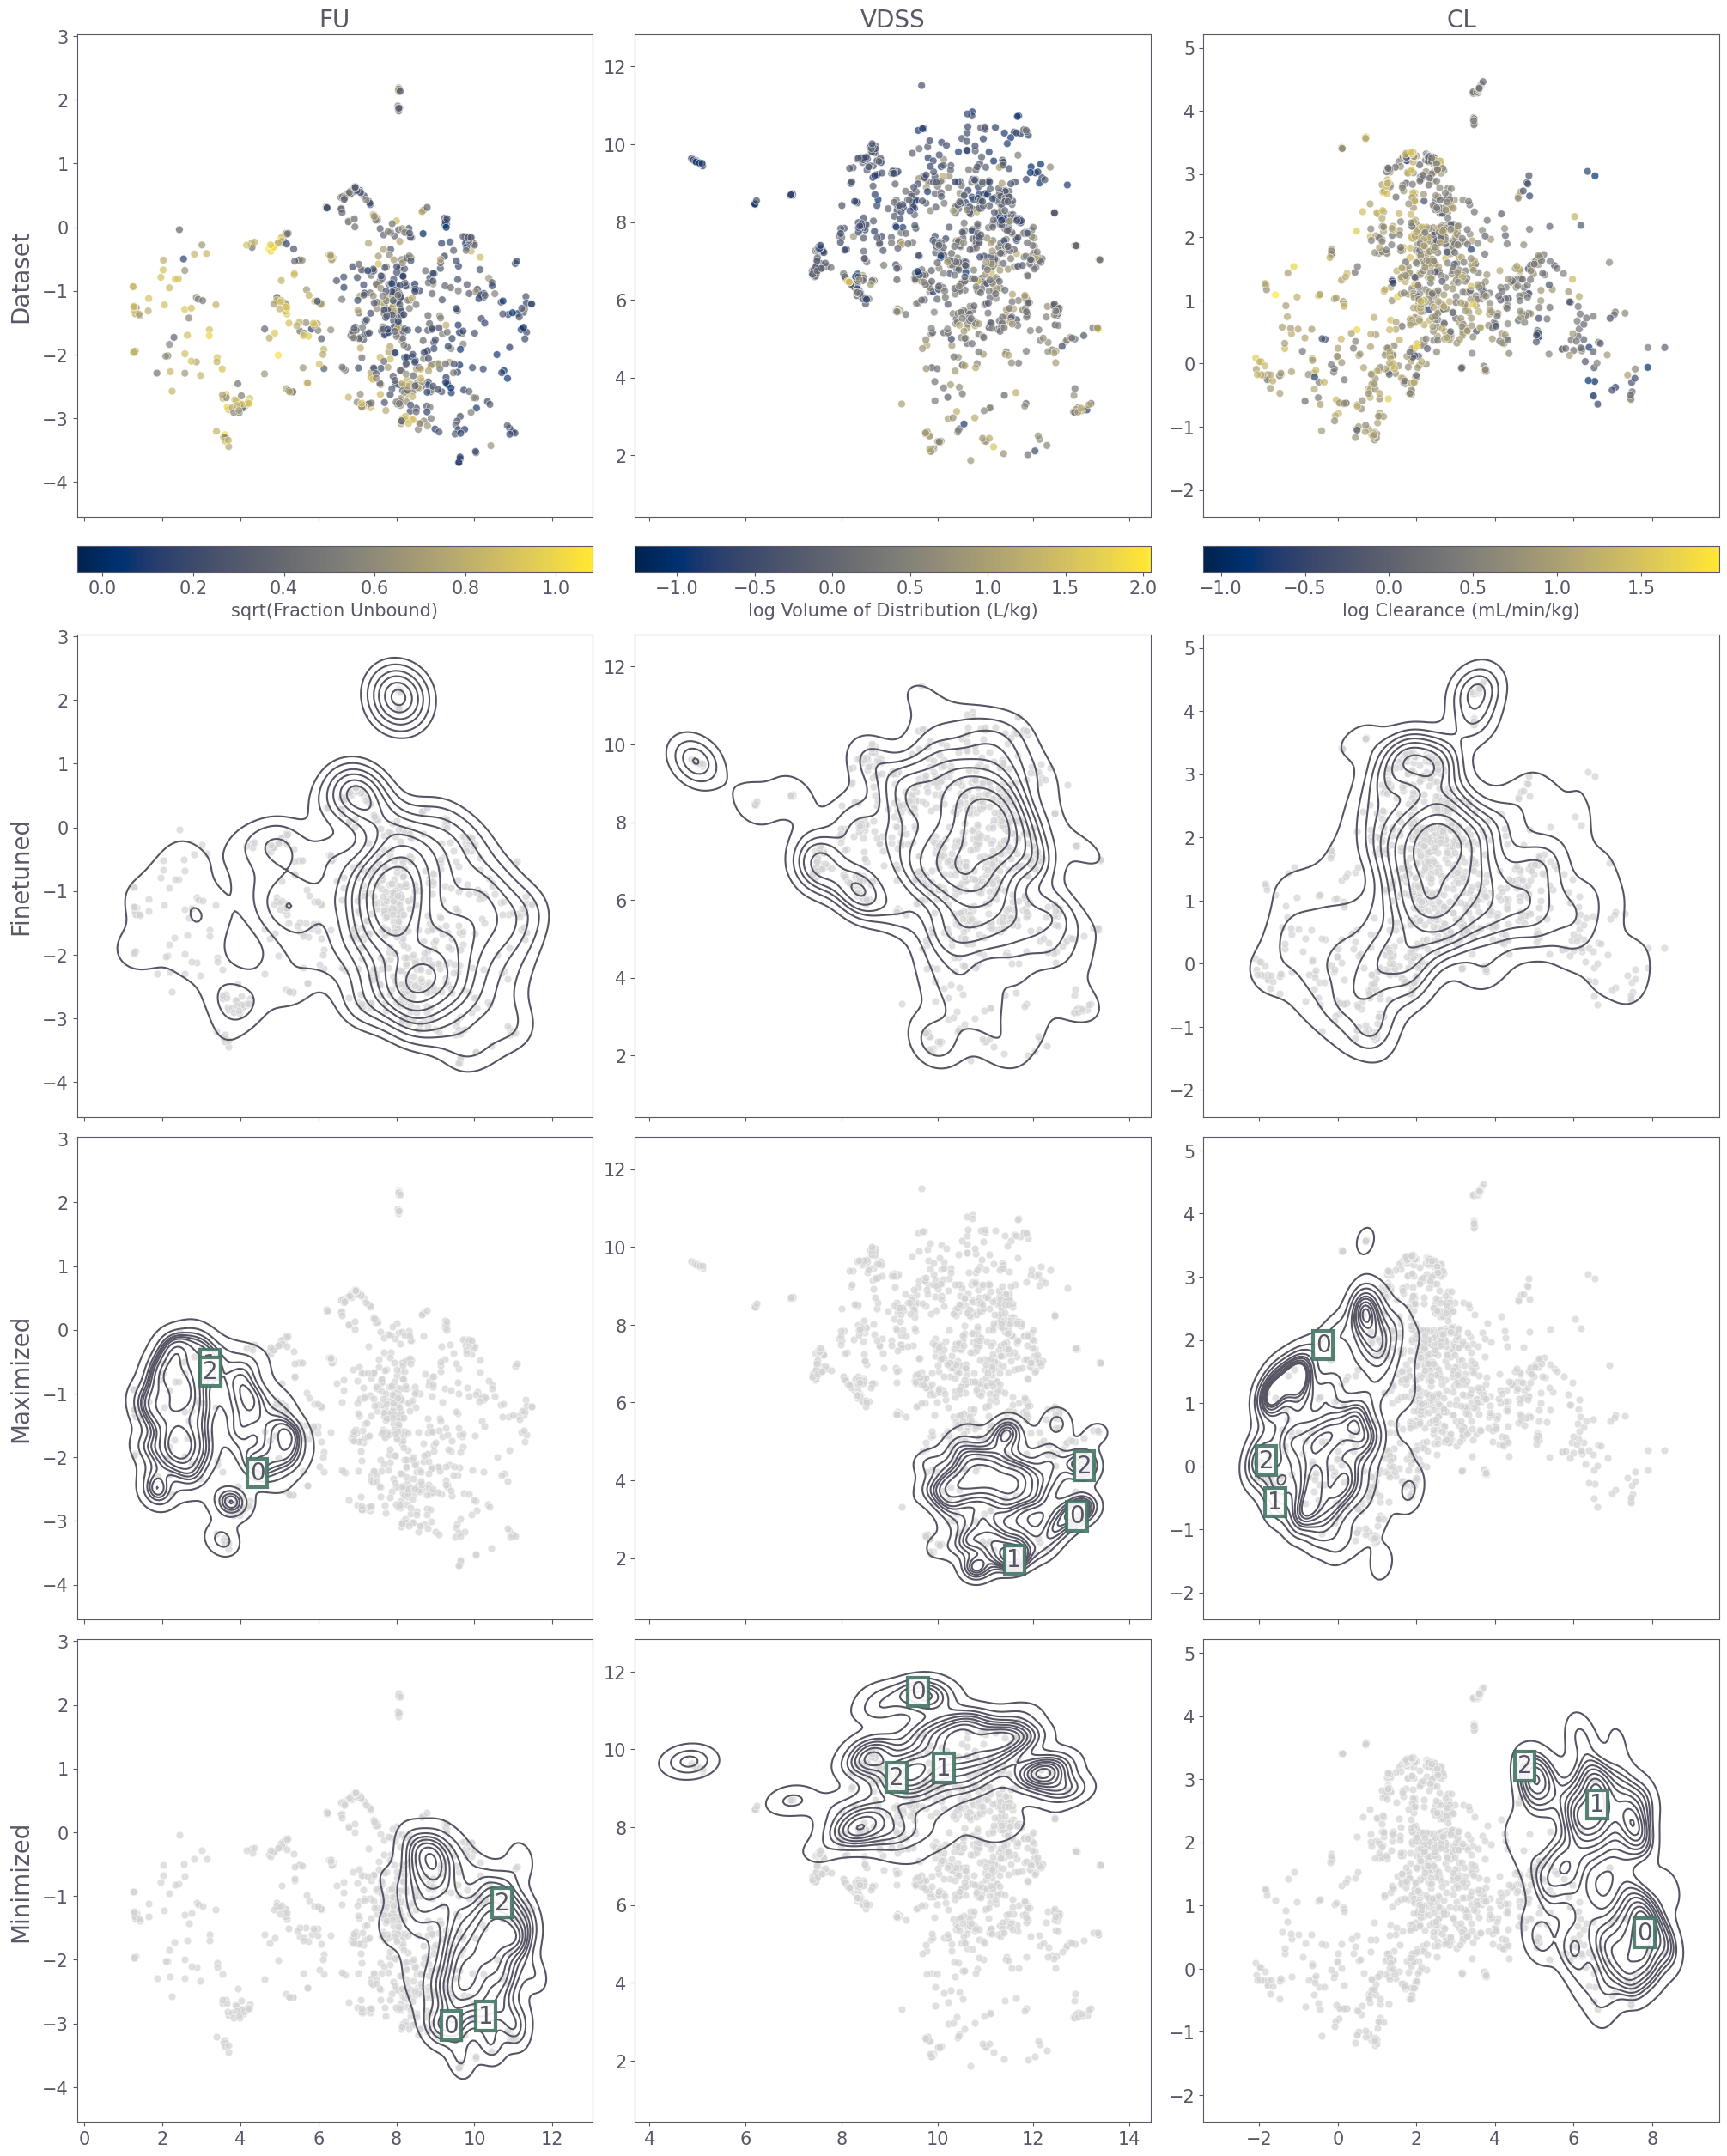

In [ ]:
#####------------------------UMAP PLOTS OF PK PROPERTIES (Supplementary Figure S7)---------------------------#####
os.makedirs(f"{FIGURES_DIR}/umap", exist_ok=True)

# make plot with UMAP for each combination
fig, ax = plt.subplots(4, 3, figsize=(20, 25), layout="constrained", sharex='col', sharey='col')

NUM_CLUSTERS = 3
POINT_SIZE = 40
POINT_COLOR = a2arcolors[3]

## plot column for FU
df = df_dict["FUmax"]
ax[0,0].set_title("FU", size=20)
# plot dataset coloured by FU value
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,0], hue="FU_pred", s=POINT_SIZE, alpha=0.7, palette='cividis')
norm = mpl.colors.Normalize(vmin=df["FU_pred"].min(), vmax=df["FU_pred"].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,0], label="sqrt(Fraction Unbound)", orientation="horizontal")
ax[0,0].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,0], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,0], color=POINT_COLOR)
# plot maximized FU overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,0], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "FUmax"], x="UMAP1", y="UMAP2", ax=ax[2,0], color=POINT_COLOR)
# plot minimized FU overlaying dataset
df = df_dict["FUmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,0], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "FUmin"], x="UMAP1", y="UMAP2", ax=ax[3,0], color=POINT_COLOR)

## plot column for VDSS
df = df_dict["VDSSmax"]
ax[0,1].set_title("VDSS", size=20)
# plot dataset coloured by VDSS value
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,1], hue="VDSS_pred", s=POINT_SIZE, alpha=0.7, palette='cividis')
norm = mpl.colors.Normalize(vmin=df["VDSS_pred"].min(), vmax=df["VDSS_pred"].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,1], label="log Volume of Distribution (L/kg)", orientation="horizontal")
ax[0,1].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,1], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,1], color=POINT_COLOR)
# plot maximized VDSS overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,1], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "VDSSmax"], x="UMAP1", y="UMAP2", ax=ax[2,1], color=POINT_COLOR)
# plot minimized VDSS overlaying dataset
df = df_dict["VDSSmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,1], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "VDSSmin"], x="UMAP1", y="UMAP2", ax=ax[3,1], color=POINT_COLOR)

## plot column for CL
df = df_dict["CLmax"]
ax[0,2].set_title("CL", size=20)
# plot dataset coloured by CL value
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[0,2], hue="CL_pred", s=POINT_SIZE, alpha=0.7, palette='cividis')
norm = mpl.colors.Normalize(vmin=df["CL_pred"].min(), vmax=df["CL_pred"].max())
sm = plt.cm.ScalarMappable(cmap='cividis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax[0,2], label="log Clearance (mL/min/kg)", orientation="horizontal")
ax[0,2].get_legend().remove()
# plot finetuned overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[1,2], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "finetuned"], x="UMAP1", y="UMAP2", ax=ax[1,2], color=POINT_COLOR)
# plot maximized CL overlaying dataset
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[2,2], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "CLmax"], x="UMAP1", y="UMAP2", ax=ax[2,2], color=POINT_COLOR)
# plot minimized CL overlaying dataset
df = df_dict["CLmin"]
sns.scatterplot(data=df[df["source"] == "dataset"], x="UMAP1", y="UMAP2", ax=ax[3,2], s=POINT_SIZE, alpha=0.7, color="lightgrey")
sns.kdeplot(data=df[df["source"] == "CLmin"], x="UMAP1", y="UMAP2", ax=ax[3,2], color=POINT_COLOR)
     
for r, ax1 in zip(["Dataset", "Finetuned", "Maximized", "Minimized"], ax[:, 0]):
    ax2 = ax1.twinx()
    # move extra axis to the left, with offset
    ax2.yaxis.set_label_position('left')
    ax2.spines['left'].set_position(('axes', -0.1))
    # hide spines and ticks, set group label
    ax2.spines[['left', 'top', 'bottom', 'right']].set_visible(False)
    ax2.set_yticks([])
    ax2.set_ylabel(r, rotation=90, size=20,
                   ha='center', va='center')
    
for prop_ax, prop in zip(
    [ax[2,0], ax[3,0], ax[2,1], ax[3,1], ax[2,2], ax[3,2]],
    ["FUmax", "FUmin", "VDSSmax", "VDSSmin", "CLmax", "CLmin"]
):
    df = df_dict[prop]
    centroids = centroids_dict[prop]
    for cluster, centroid in centroids[:NUM_CLUSTERS].SMILES.items():
        cluster_center = df[df["SMILES"] == centroid]
        prop_ax.text(
            cluster_center["UMAP1"].iloc[0], cluster_center["UMAP2"].iloc[0],
            cluster, fontsize=20,
            bbox=dict(
                facecolor='white', alpha=0.9, pad=2, 
                edgecolor=a2arcolors[2], linewidth=3
            ),
            ha='center', va='center', color=a2arcolors[3]
        )

# remove x and y labels
for i in range(4):
    for j in range(3):
        ax[i,j].set_xlabel("")
        ax[i,j].set_ylabel("")

plt.savefig(f"{FIGURES_DIR}/umap/umap_pk.png", bbox_inches="tight", dpi=500)
plt.show()